# Refraction Traveltime Tomography

### Author: M.Ravasi

This notebook creates the machinery to define a geometry, shoot rays, and extract those rays corresponding to available pairs of sources and receivers.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy.optimize import least_squares
from scipy.signal import filtfilt
from scipy.sparse.linalg import lsqr
from pylops.basicoperators import *
from pylops.optimization.leastsquares import *

from refrtomo.invert import *
from refrtomo.raytrace import raytrace
from refrtomo.survey import *
from refrtomo.tomomatrix import *

## Velocity model

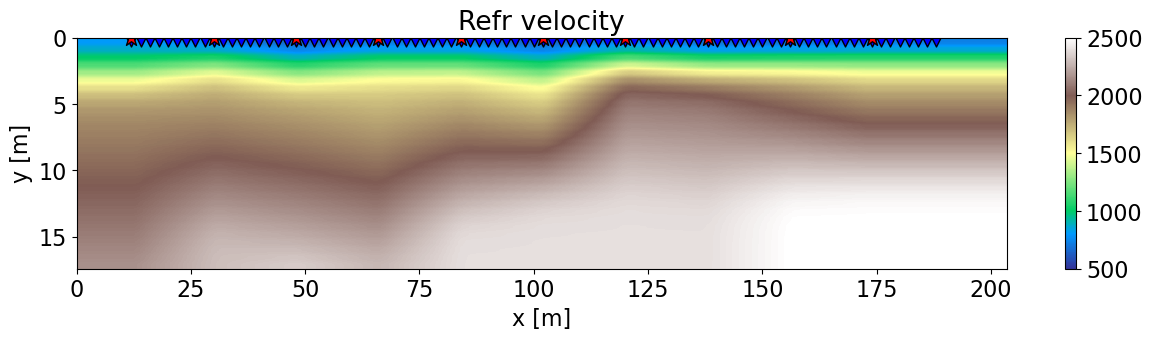

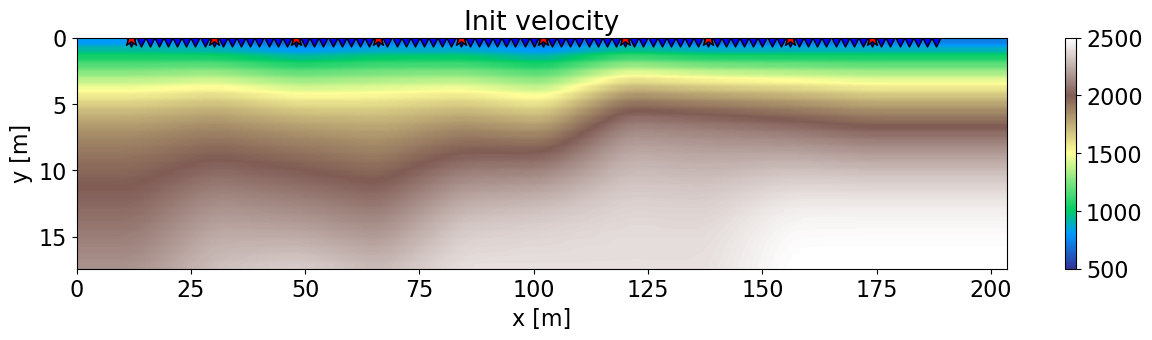

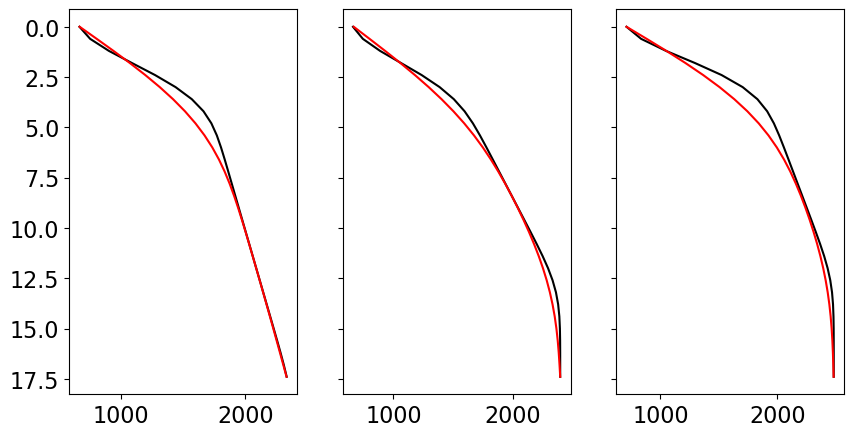

In [2]:
# Velocity model
fvel = np.load('../data/VelRefractionStryde.npz')
ftrav =  np.load('../data/FirstArrivalTravStryde.npz')

sc = 10. # from m to dm
x, z = fvel['x'] * sc, fvel['z'][:30] * sc
nx, nz = x.size, z.size
dx, dz = x[1]-x[0], z[1]-z[0]
vel_refr = fvel['vel'][:, :30] * sc
tobs = ftrav['tfirst']

# Pad model to last receiver
nxpad = (20, 50)
nx = nx + np.sum(nxpad)
x = np.arange(nx) * dx
vel_refr = np.pad(vel_refr, (nxpad, (0, 0)), mode='edge')

# Initial velocity
nsmooth = 5
vel_init = vel_refr.copy()
for _ in range(4):
    vel_init = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_init, axis=1)
    vel_init = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_init, axis=0)

#vel_init = np.tile(700 + 11. * z, (nx, 1)) * sc

# Receivers
rx = ftrav['xr'] * sc + nxpad[0] * dx
nr = rx.size
rz = 0*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
sx = ftrav['xs'] * sc + nxpad[0] * dx
ns = sx.size
sz = 0*np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

plt.figure(figsize=(15,3))
im = plt.imshow(vel_refr.T / sc, cmap='terrain', vmin=500, vmax=2500, 
                extent=(x[0] / sc, x[-1] / sc, z[-1] / sc, z[0] / sc))
plt.scatter(recs[0] / sc, recs[1] / sc, marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0] / sc, sources[1] / sc, marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Refr velocity')
plt.ylim(z[-1] / sc, z[0] / sc);

plt.figure(figsize=(15,3))
im = plt.imshow(vel_init.T / sc, cmap='terrain', vmin=500, vmax=2500, 
                extent=(x[0] / sc, x[-1] / sc, z[-1] / sc, z[0] / sc))
plt.scatter(recs[0] / sc, recs[1] / sc, marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0] / sc, sources[1] / sc, marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Init velocity')
plt.ylim(z[-1] / sc, z[0] / sc);

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10,5))
for ax, ix in zip(axs, [nx//4, nx//2, 3*nx//4]):
    ax.plot(vel_refr[ix] / sc, z / sc, 'k')
    ax.plot(vel_init[ix] / sc, z / sc, 'r')
axs[-1].invert_yaxis()

## Survey geometry

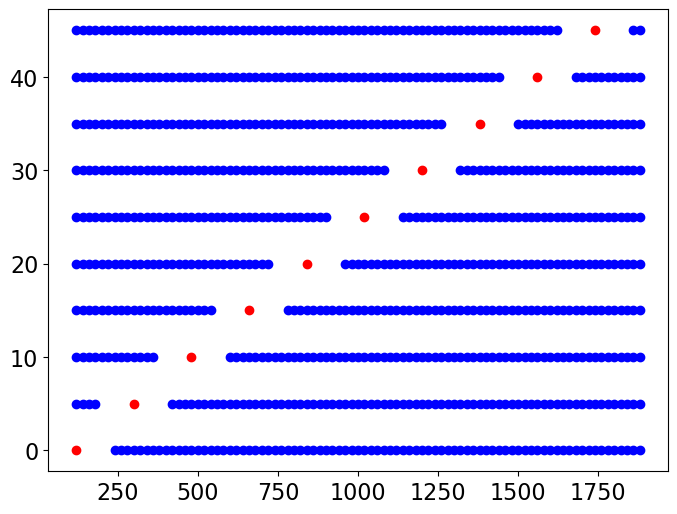

In [3]:
srcs = np.vstack((sx, sz))
recs = np.vstack((rx, rz))

survey = survey_geom(srcs, recs, minoffset=10 * sc)
avasurvey = survey_geom_observed(srcs, recs, tobs, minoffset=10 * sc)

display_survey(survey)

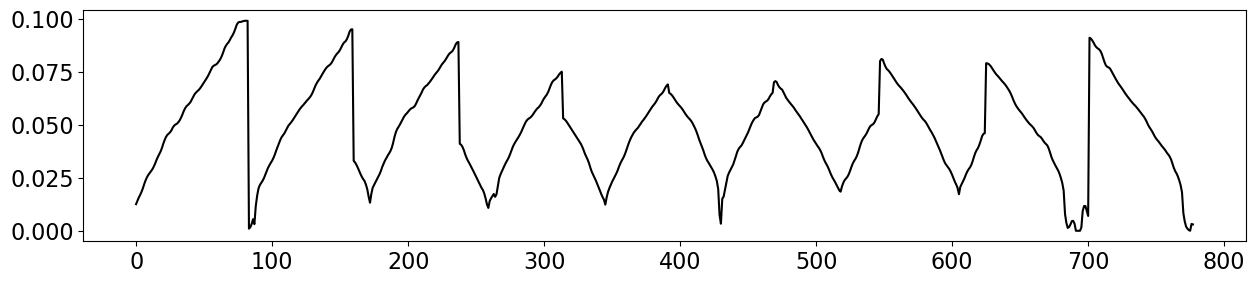

In [4]:
tobs = extract_tobs(avasurvey)

plt.figure(figsize=(15, 3))
plt.plot(tobs, 'k');

## Raytrace all sources

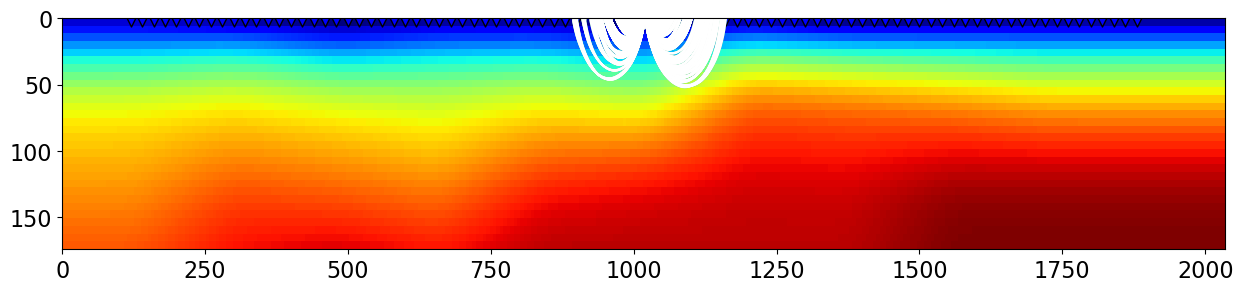

In [5]:
# Trace one source rays
lmax = 2e3
nl = 2000
thetas = np.hstack([np.arange(-89, -20, 0.1), np.arange(20, 89, 0.1)])

# Raytrace
rays, rays_turning, thetas_turning = raytrace(vel_init.T, x, z, dx, dz, 
                                              lmax, nl, survey[ns//2].src, 
                                              thetas, dzout=1. * sc)

plt.figure(figsize=(15, 3))
plt.imshow(vel_init.T, cmap='jet', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(survey[ns//2].rec[0], survey[ns//2].rec[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(survey[ns//2].src[0], survey[ns//2].src[1], marker='*', s=150, c='r', edgecolors='k')
for ray in rays:
    plt.plot(ray[:,0], ray[:,1], '#3FB97E')
for ray in rays_turning:
    plt.plot(ray[:,0], ray[:,1], 'w')
plt.axis('tight');

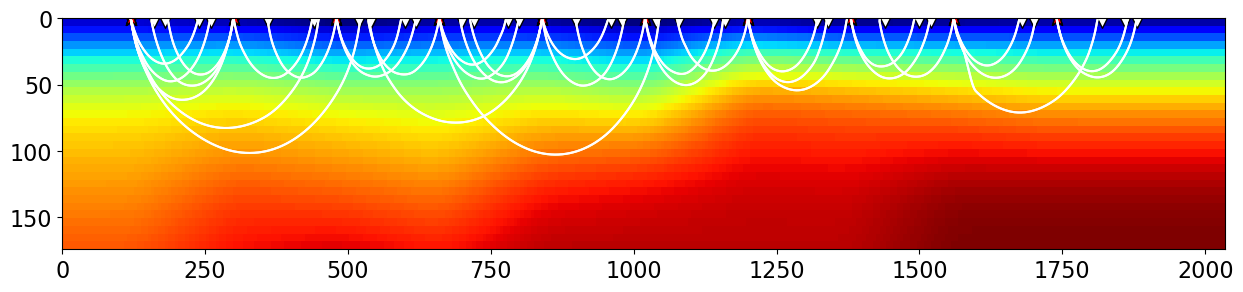

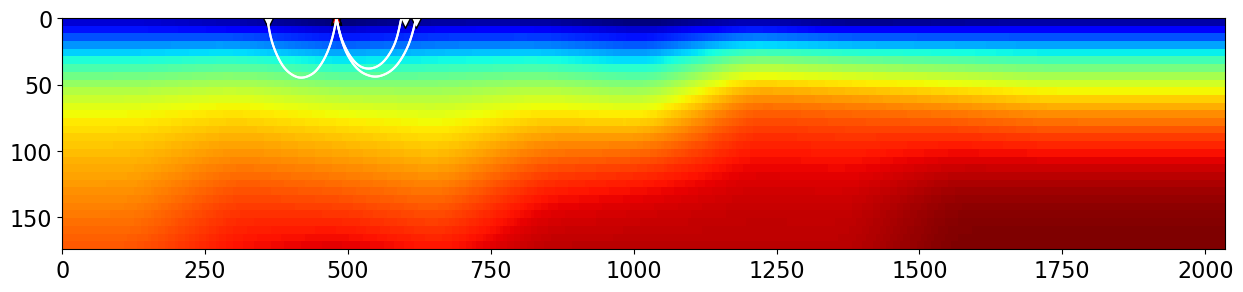

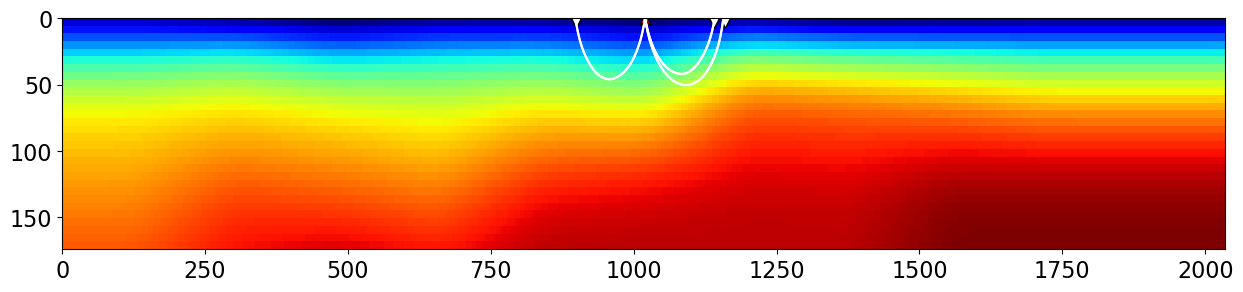

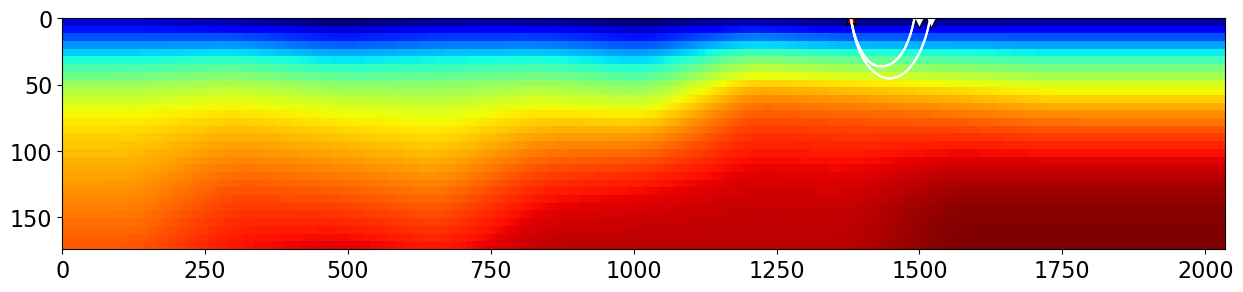

In [6]:
# Trace all rays
initsurvey = survey_raytrace(survey, vel_init.T, x, z, lmax, nl, thetas, 
                             dzout=1. * sc, ray_rec_mindistance=1. * sc)

# Display rays
display_survey_rays(initsurvey, vel_init.T, x, z, figsize=(15, 3))
display_survey_rays(initsurvey, vel_init.T, x, z, sx=sx[ns//4], figsize=(15, 3))
display_survey_rays(initsurvey, vel_init.T, x, z, sx=sx[ns//2], figsize=(15, 3))
display_survey_rays(initsurvey, vel_init.T, x, z, sx=sx[3*ns//4], figsize=(15, 3))

## Initial rays and traveltimes

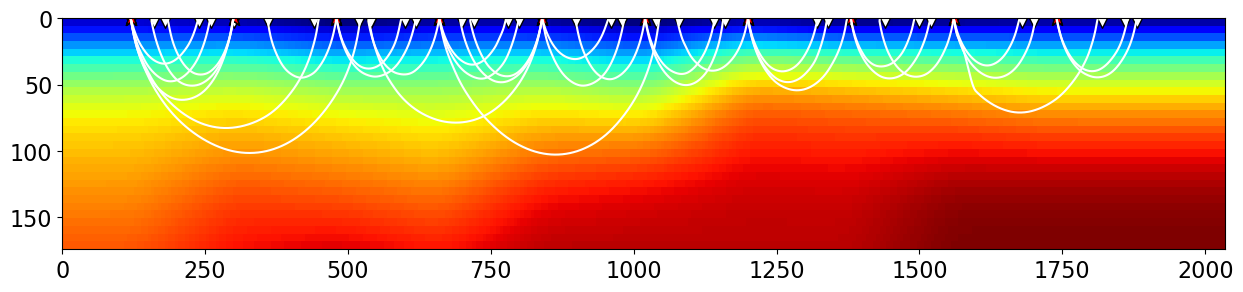

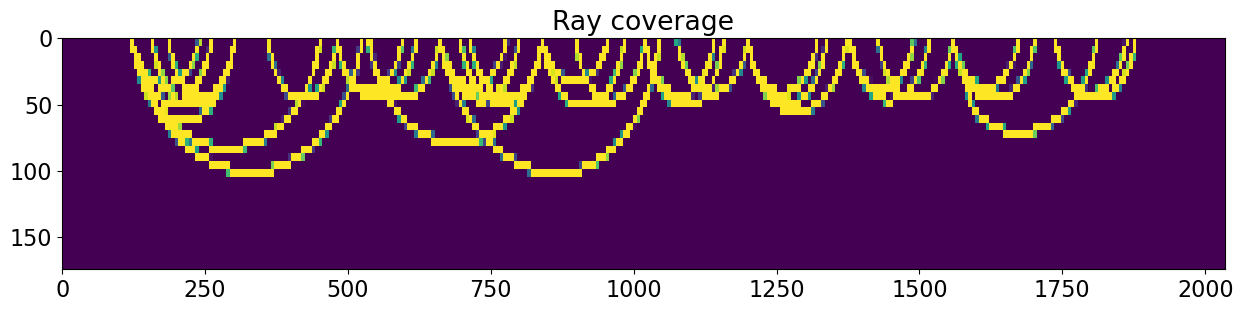

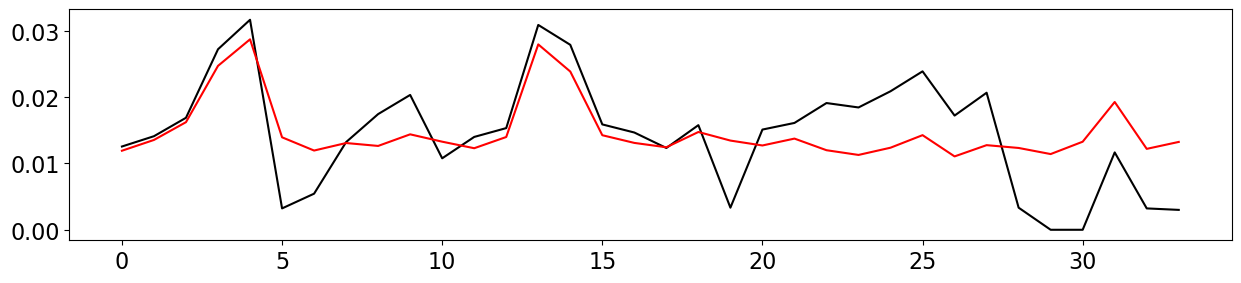

In [7]:
# Raytrace in initial model
#initsurvey = survey_raytrace(survey, vel_init.T, x, z, lmax, nl, thetas, dzout=5., ray_rec_mindistance=5.)

# Match surveys
avasurvey_matched, initsurvey_matched = match_surveys(avasurvey, initsurvey)

# Tomographic matrix and traveltimes
Rinit = tomographic_matrix(initsurvey_matched, dx, dz, 0, 0, nx, nz, x, z, plotflag=True, vel=vel_init)
tinit = Rinit @ (1. / vel_init.ravel())

# Observed traveltimes
tobs = extract_tobs(avasurvey_matched)

plt.figure(figsize=(15, 3))
plt.plot(tobs, 'k')
plt.plot(tinit, 'r');

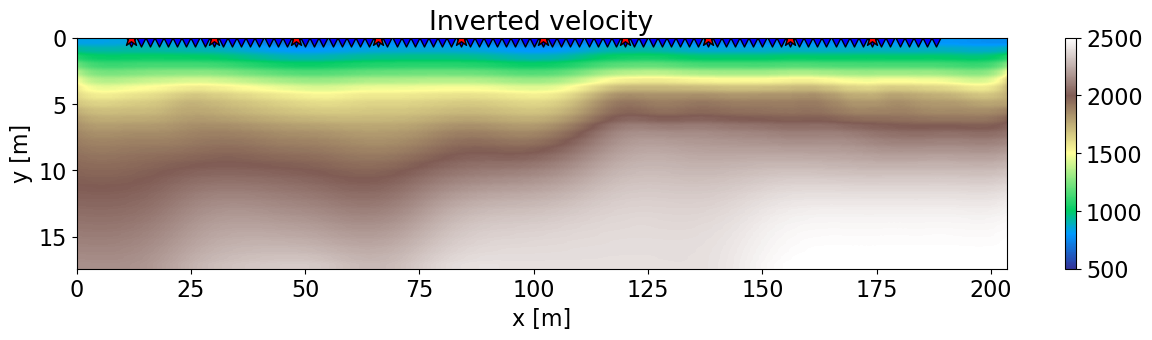

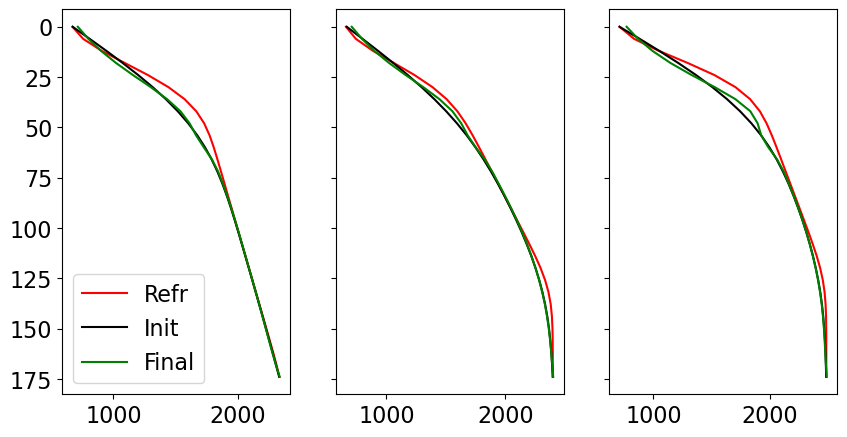

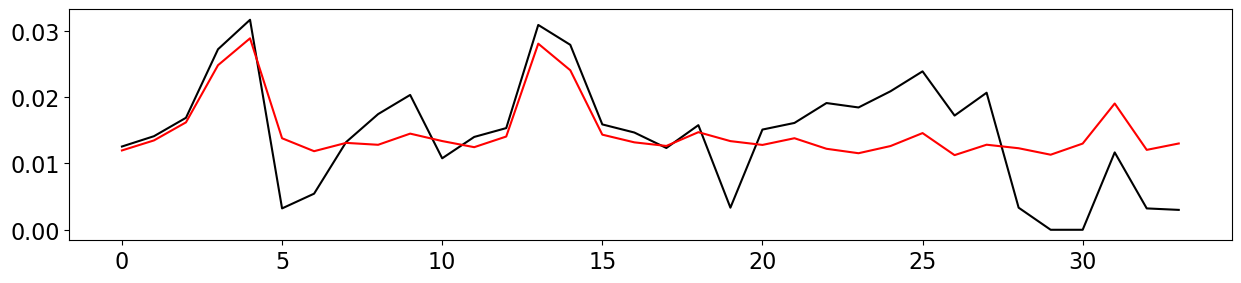

In [8]:
# Invert slowness model
Dop = Laplacian((nx, nz), weights=(10, 1))
slowninv = regularized_inversion(MatrixMult(Rinit), 
                                 tobs, [Dop,], epsRs=[3e2, ], 
                                 x0=1./vel_init.ravel(), 
                                 **dict(iter_lim=100, damp=1e-1))[0]
vel_inv = 1. / (slowninv.reshape(nx, nz) + 1e-10)
tinv = Rinit @ (1. / vel_inv.ravel())

plt.figure(figsize=(15,3))
im = plt.imshow(vel_inv.T / sc, cmap='terrain', vmin=500, vmax=2500, 
                extent=(x[0] / sc, x[-1] / sc, z[-1] / sc, z[0] / sc))
plt.scatter(recs[0] / sc, recs[1] / sc, marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0] / sc, sources[1] / sc, marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Inverted velocity')
plt.ylim(z[-1] / sc, z[0] / sc)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10,5))
for ax, ix in zip(axs, [nx//4, nx//2, 3*nx//4]):
    ax.plot(vel_refr[ix] / sc, z, 'r', label='Refr')
    ax.plot(vel_init[ix] / sc, z, 'k', label='Init')
    ax.plot(vel_inv[ix] / sc, z, 'g', label='Final')
    if ix == nx // 4:
        ax.legend()
axs[-1].invert_yaxis()

plt.figure(figsize=(15, 3))
plt.plot(tobs, 'k')
plt.plot(tinv, 'r');

## Naive Gauss-Newton method

Iteration 1/10, Misfit 0.0013
Iteration 2/10, Misfit 0.0011
Iteration 3/10, Misfit 0.0016
Iteration 4/10, Misfit 0.0008
Iteration 5/10, Misfit 0.0008
Iteration 6/10, Misfit 0.0007
Iteration 7/10, Misfit 0.0006
Iteration 8/10, Misfit 0.0007
Iteration 9/10, Misfit 0.0006
Iteration 10/10, Misfit 0.0006


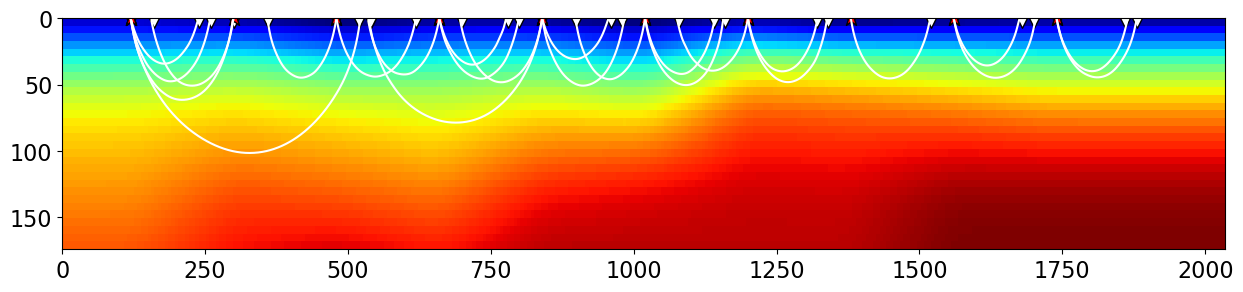

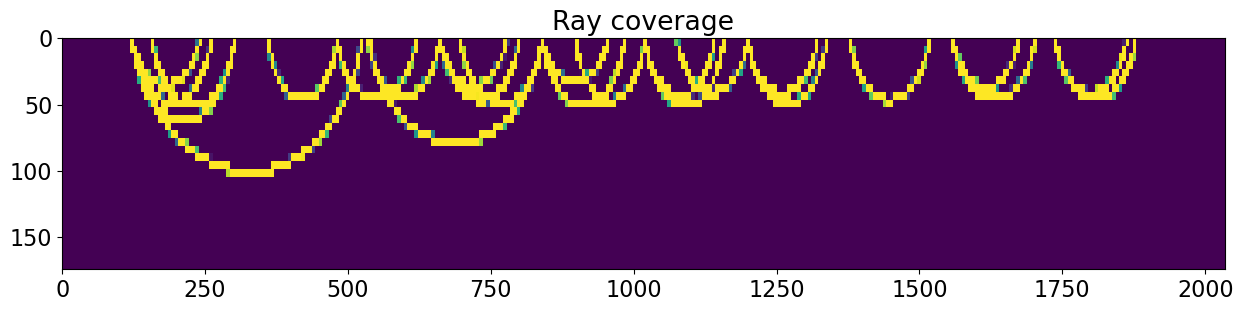

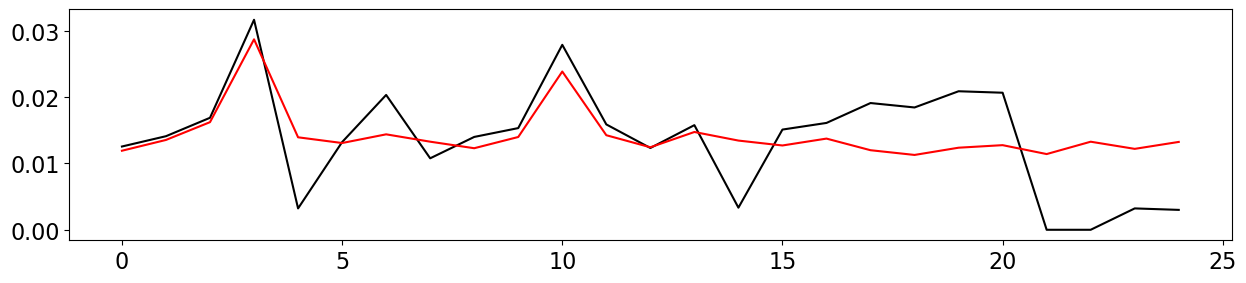

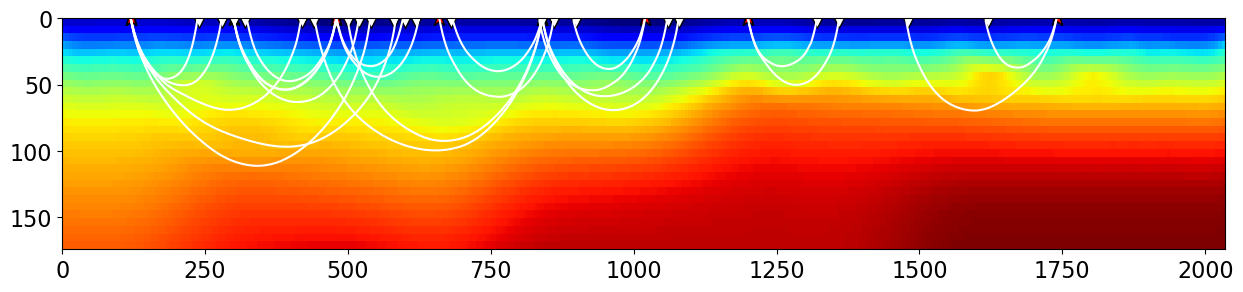

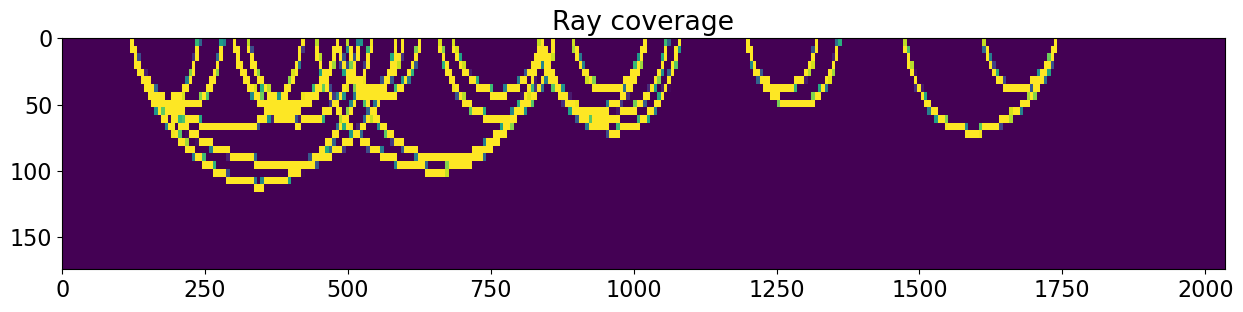

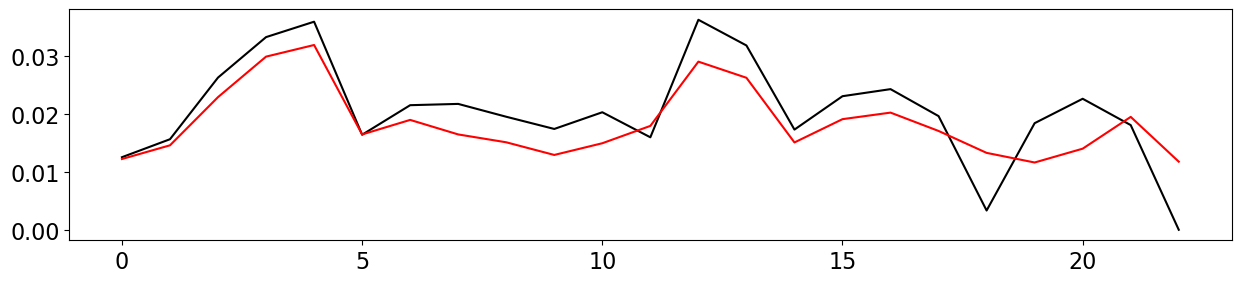

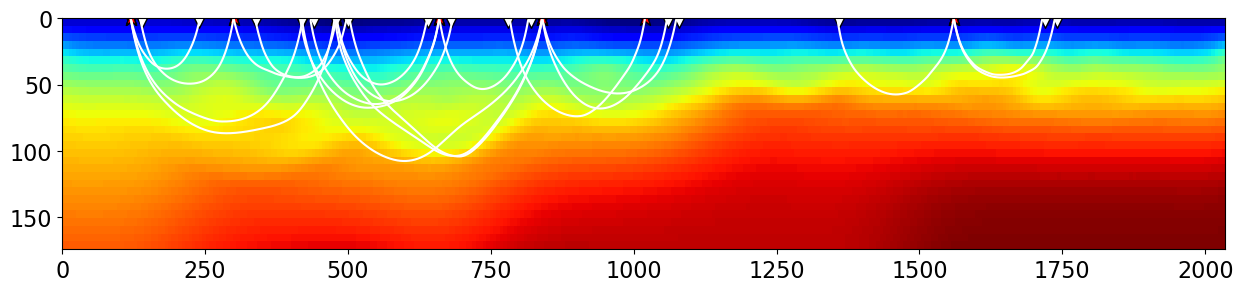

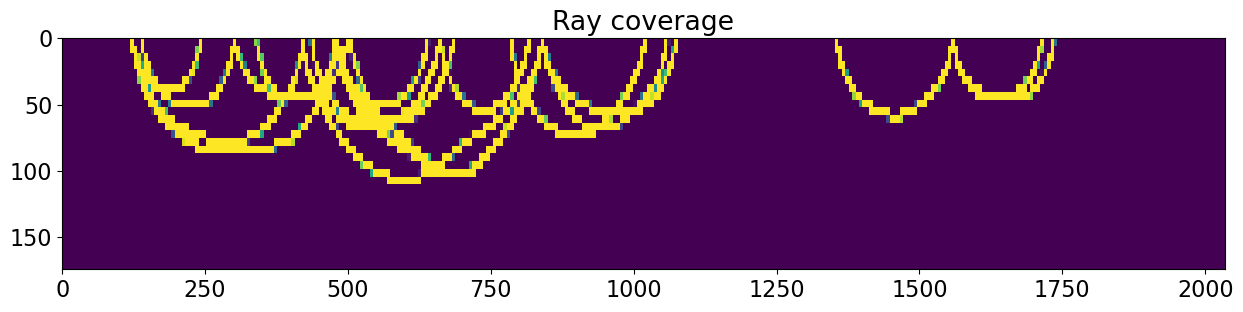

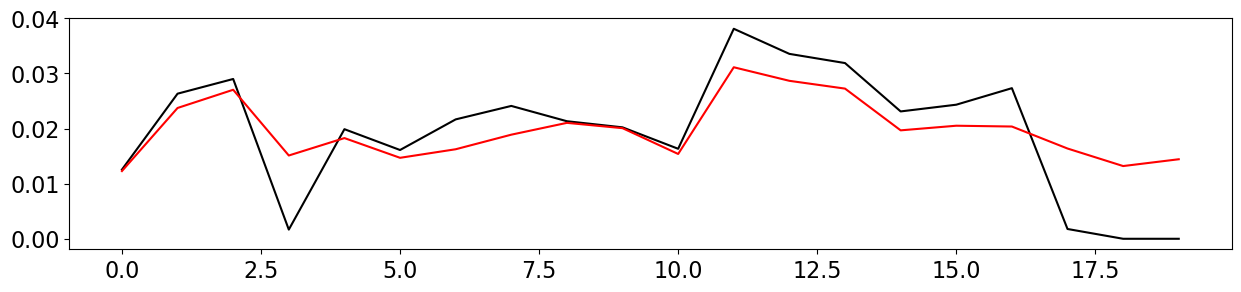

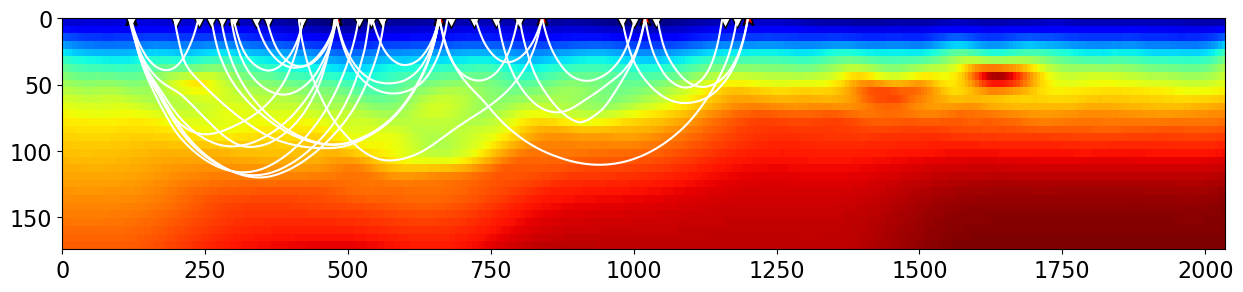

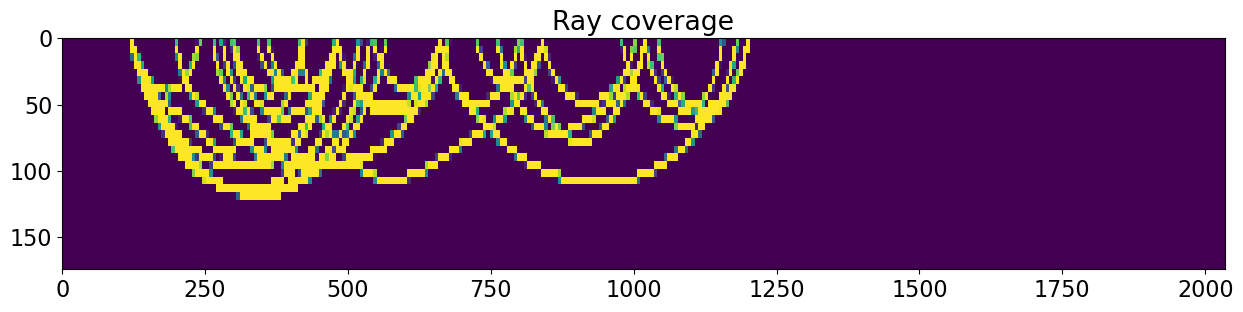

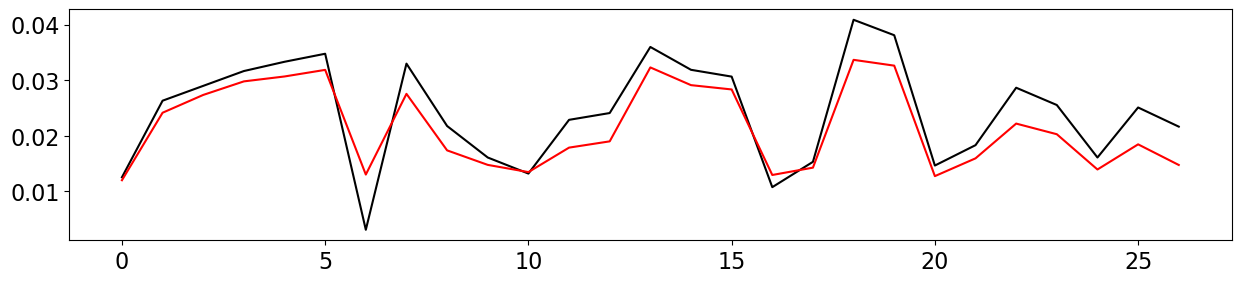

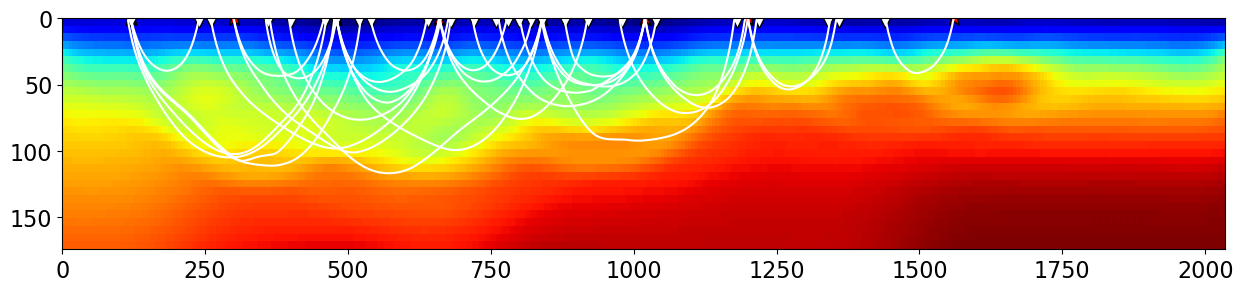

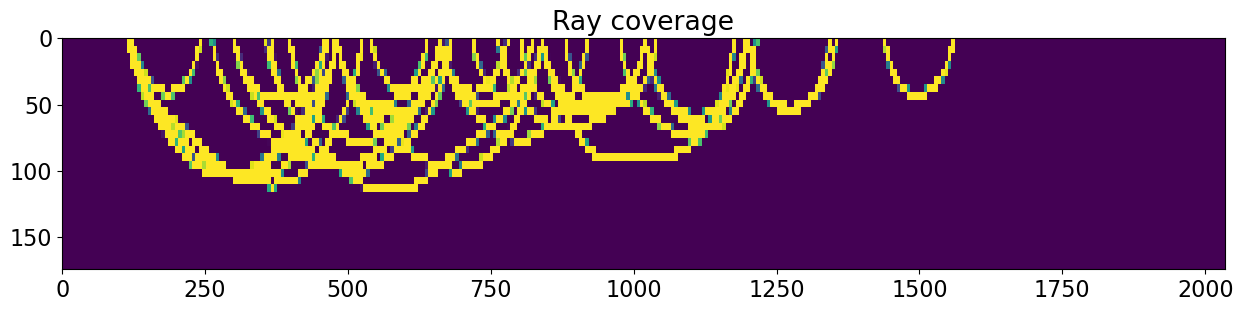

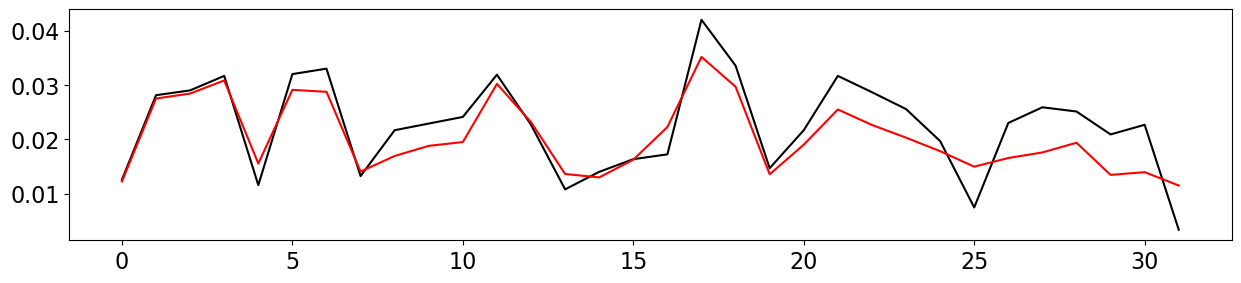

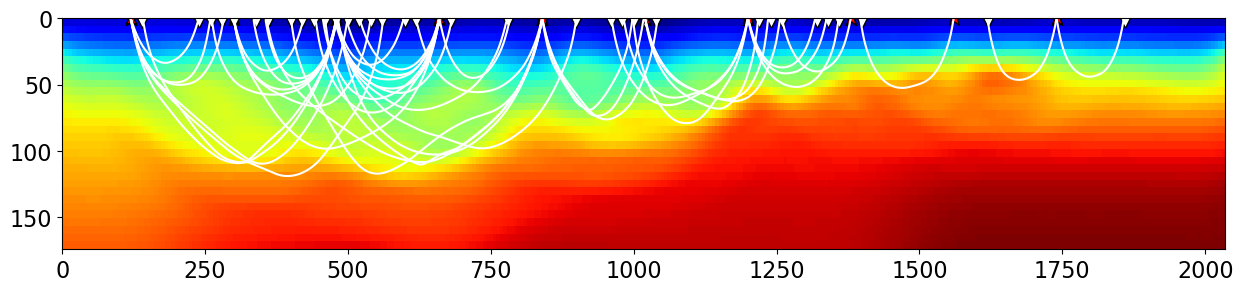

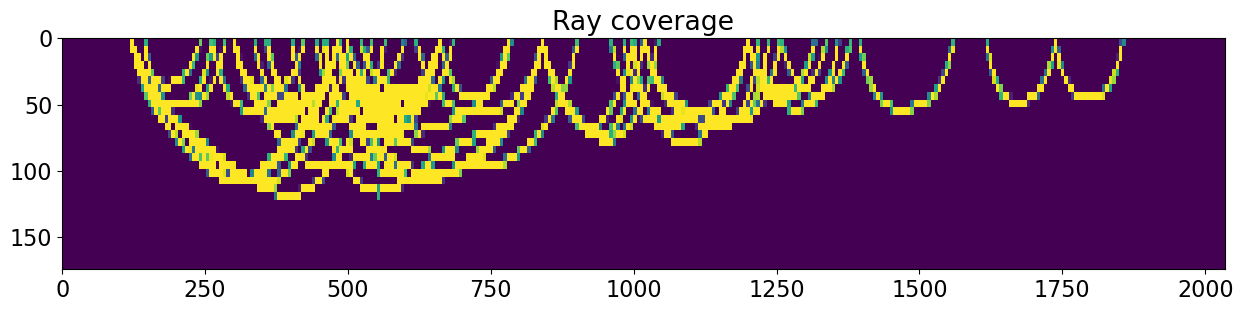

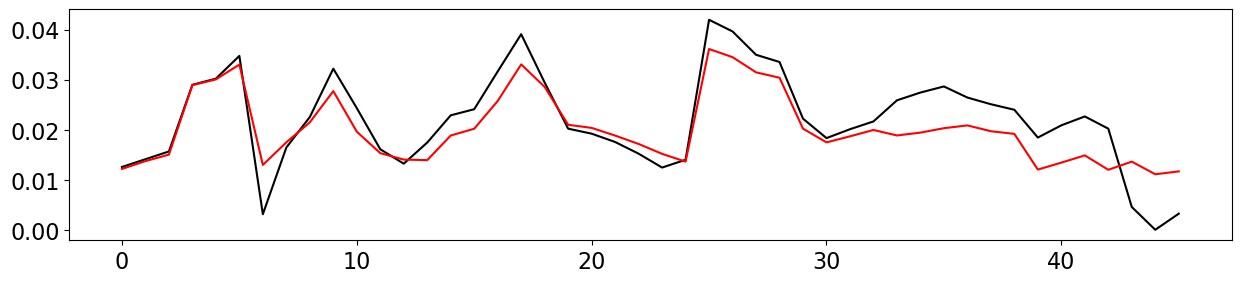

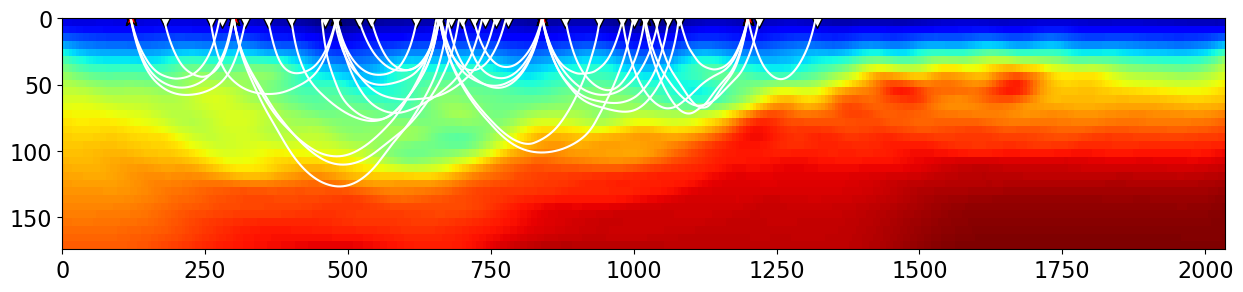

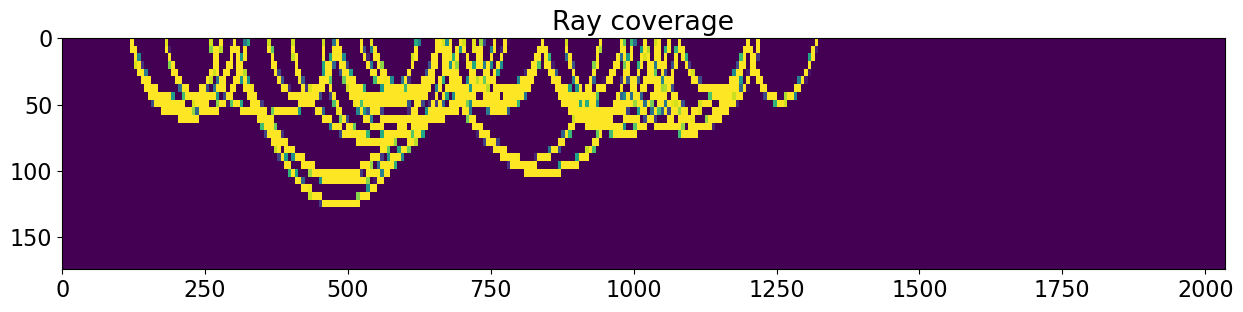

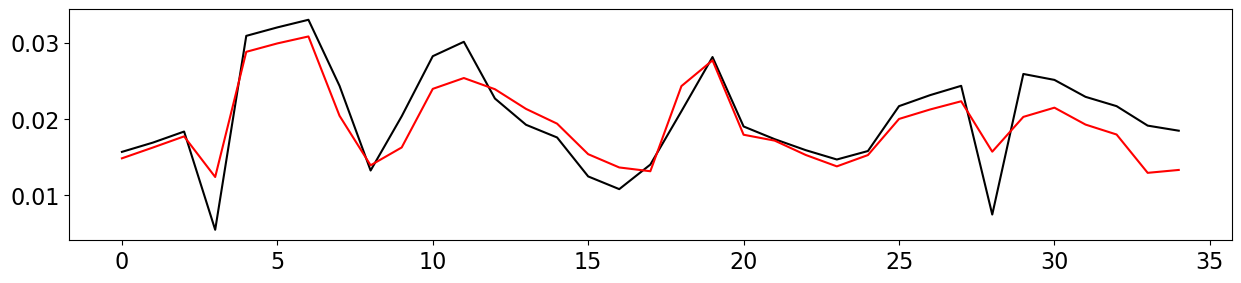

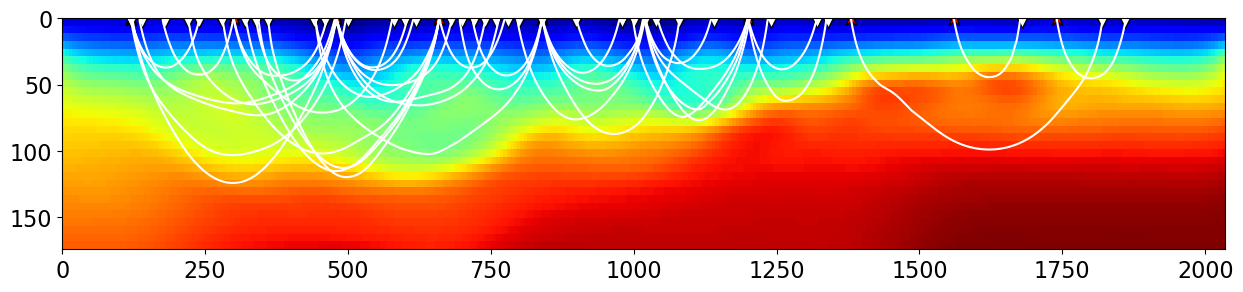

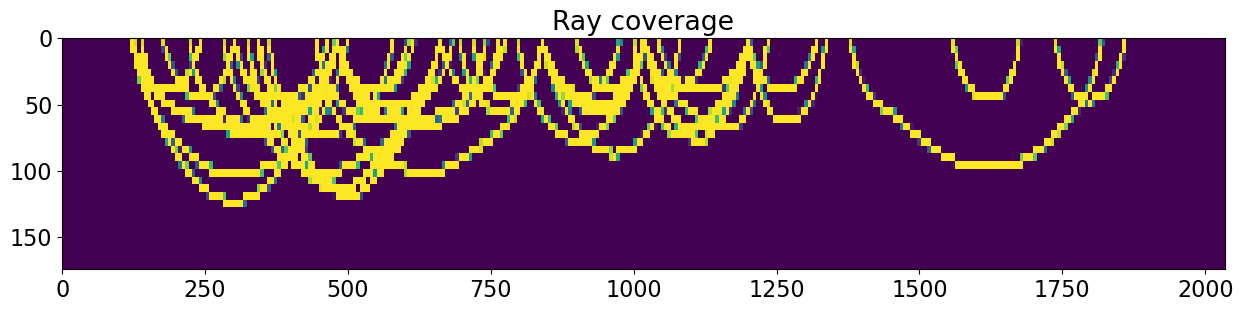

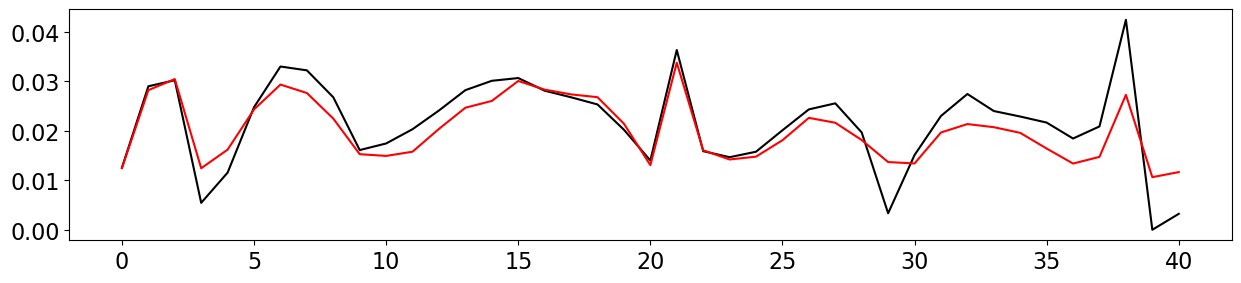

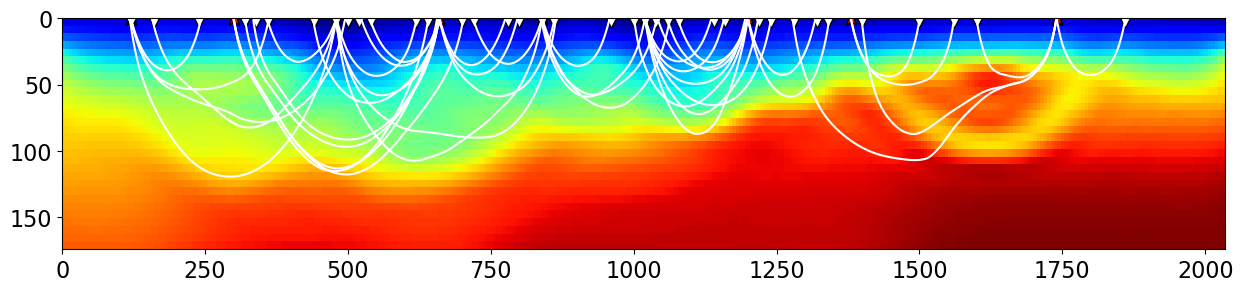

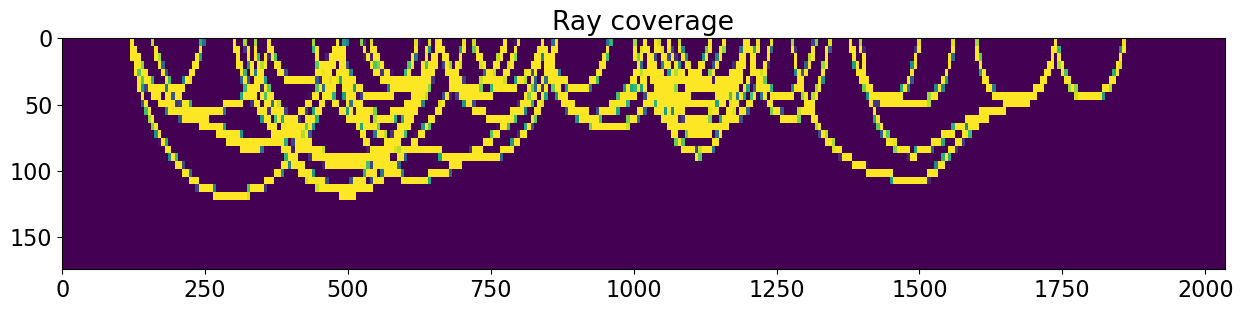

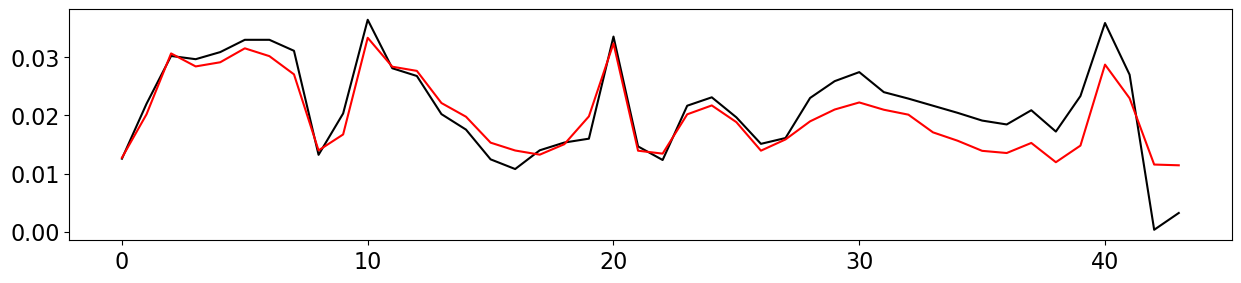

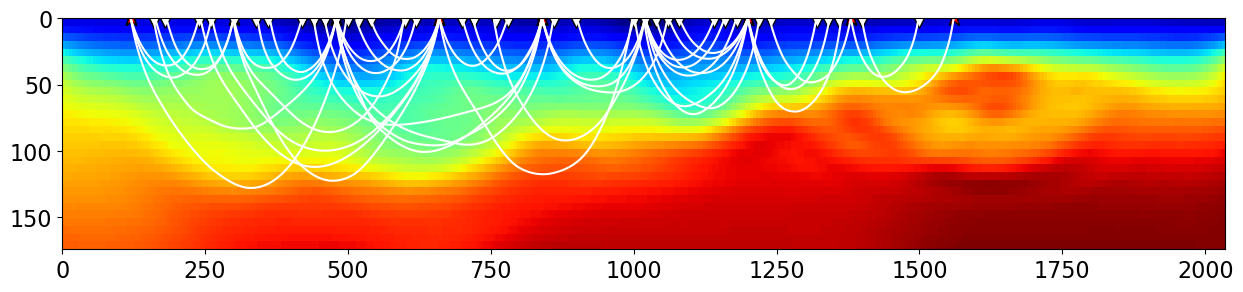

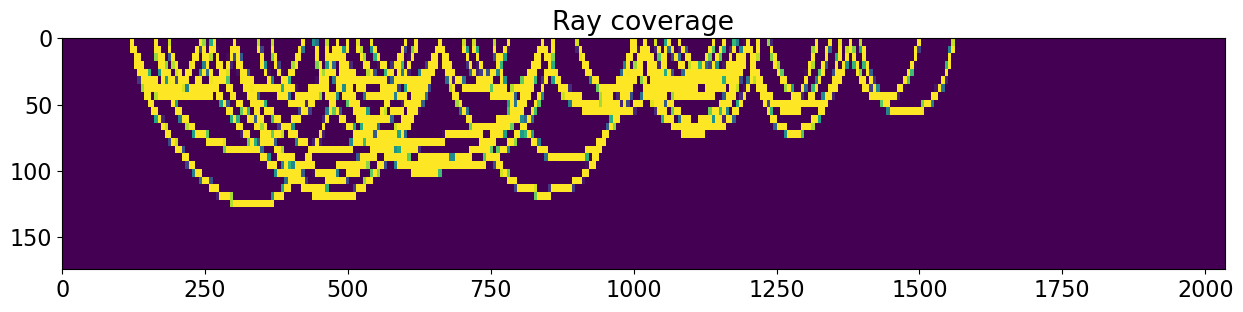

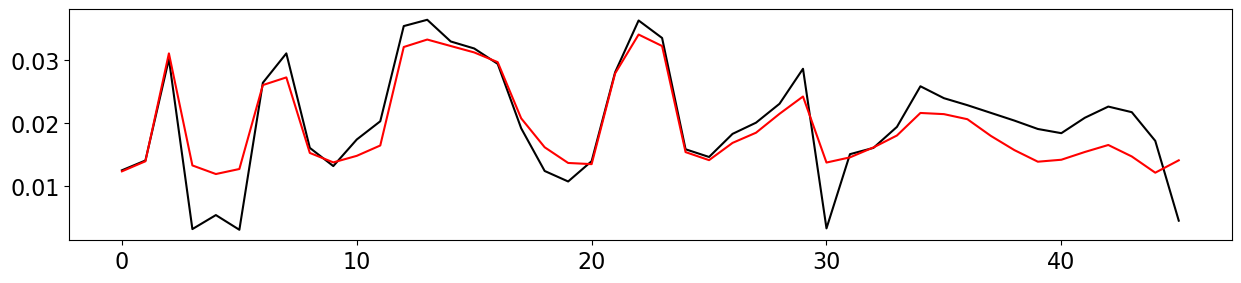

In [9]:
# first version, updating slow with full tobs at each step
ngniter = 10

Dop = Laplacian((nx, nz), weights=(10, 1))
vel_inv = vel_init.copy()
misfit = []
for iiter in range(ngniter):
    # Raytrace in initial model
    invsurvey = survey_raytrace(survey, vel_inv.T, x, z, lmax, nl, thetas, dzout=5., ray_rec_mindistance=5.)

    # Match surveys
    avasurvey_matched, invsurvey_matched = match_surveys(avasurvey, invsurvey)

    # Tomographic matrix and traveltimes
    Rinv = tomographic_matrix(invsurvey_matched, dx, dz, 0, 0, nx, nz, x, z, plotflag=True, vel=vel_inv)
    tobs = extract_tobs(avasurvey_matched)
    tinv = Rinv @ (1./vel_inv.ravel())
    plt.figure(figsize=(15, 3))
    plt.plot(tobs, 'k')
    plt.plot(tinv, 'r')
    misfit.append(np.linalg.norm(tobs - tinv) / len(tobs))
    print(f'Iteration {iiter+1}/{ngniter}, Misfit {misfit[-1]:.4f}')
    
    # Invert slowness model (just few iterations to avoid overfitting at each step)
    slowninv = regularized_inversion(MatrixMult(Rinv), 
                                     tobs, [Dop,], epsRs=[1e2,], 
                                     x0=1./vel_inv.ravel(), 
                                     **dict(iter_lim=40, damp=1e-1))[0]
    vel_inv = 1. / (slowninv.reshape(nx, nz) + 1e-10)

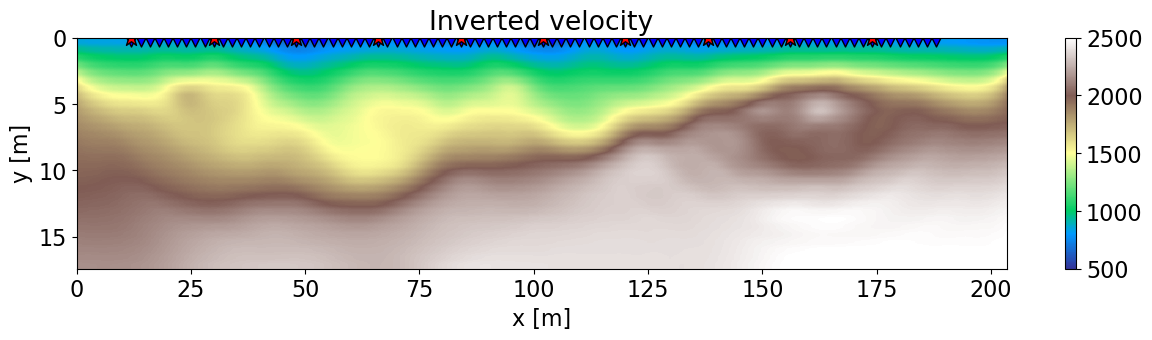

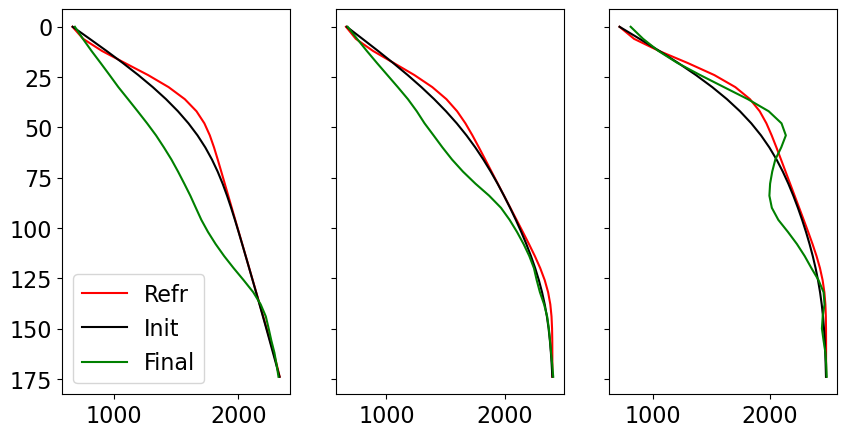

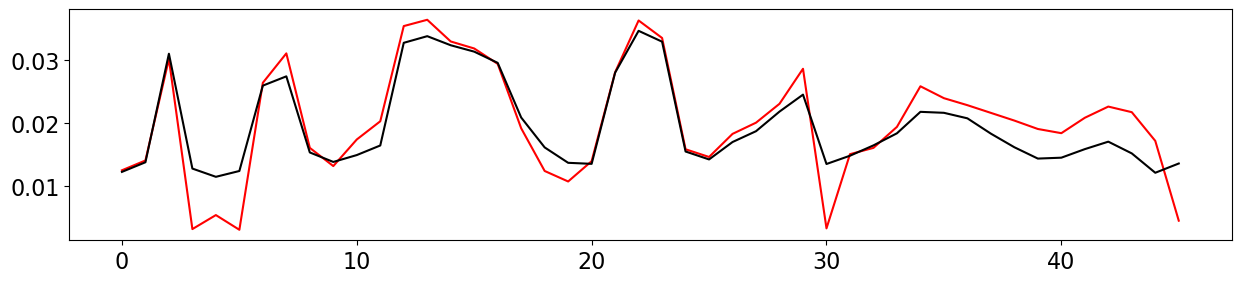

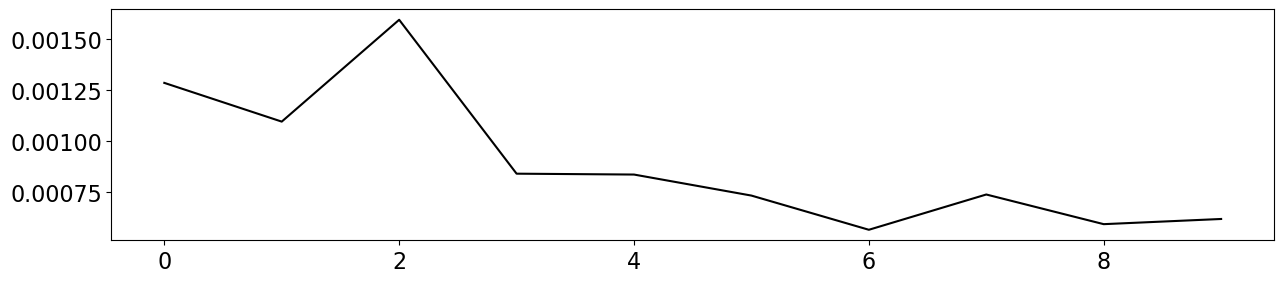

In [10]:
plt.figure(figsize=(15,3))
im = plt.imshow(vel_inv.T / sc, cmap='terrain', vmin=500, vmax=2500, 
                extent=(x[0] / sc, x[-1] / sc, z[-1] / sc, z[0] / sc))
plt.scatter(recs[0] / sc, recs[1] / sc, marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0] / sc, sources[1] / sc, marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Inverted velocity')
plt.ylim(z[-1] / sc, z[0] / sc)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10,5))
for ax, ix in zip(axs, [nx//4, nx//2, 3*nx//4]):
    ax.plot(vel_refr[ix] / sc, z, 'r', label='Refr')
    ax.plot(vel_init[ix] / sc, z, 'k', label='Init')
    ax.plot(vel_inv[ix] / sc, z, 'g', label='Final')
    if ix == nx // 4:
        ax.legend()
axs[-1].invert_yaxis()

tinv = Rinv @ (1/vel_inv.ravel())

plt.figure(figsize=(15, 3))
plt.plot(tobs, 'r')
plt.plot(tinv, 'k')

plt.figure(figsize=(15, 3))
plt.plot(misfit, 'k');

Iteration 1/10, Misfit 0.0013
Iteration 2/10, Misfit 0.0011
Iteration 3/10, Misfit 0.0016
Iteration 4/10, Misfit 0.0009
Iteration 5/10, Misfit 0.0008
Iteration 6/10, Misfit 0.0007
Iteration 7/10, Misfit 0.0006
Iteration 8/10, Misfit 0.0006
Iteration 9/10, Misfit 0.0006
Iteration 10/10, Misfit 0.0006


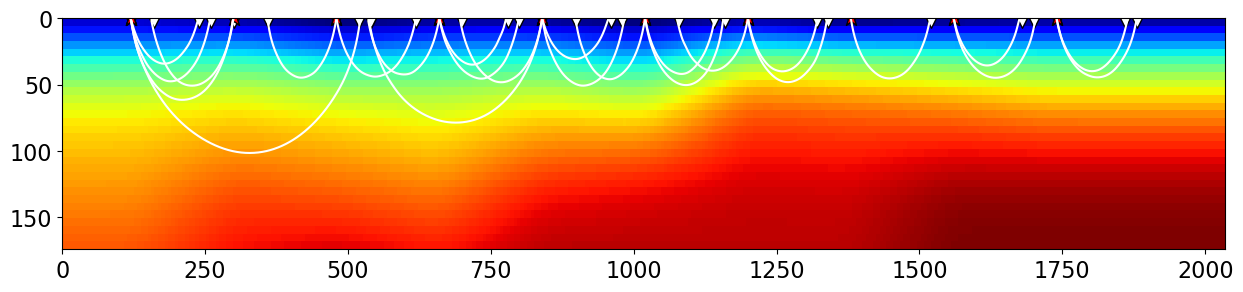

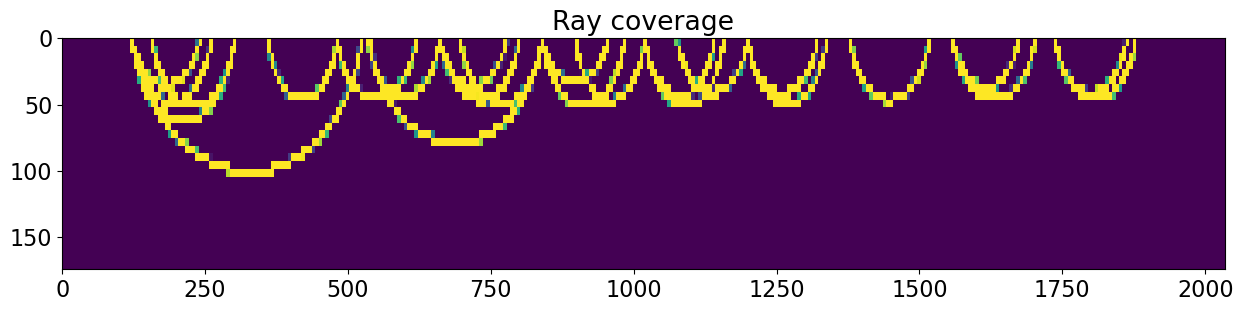

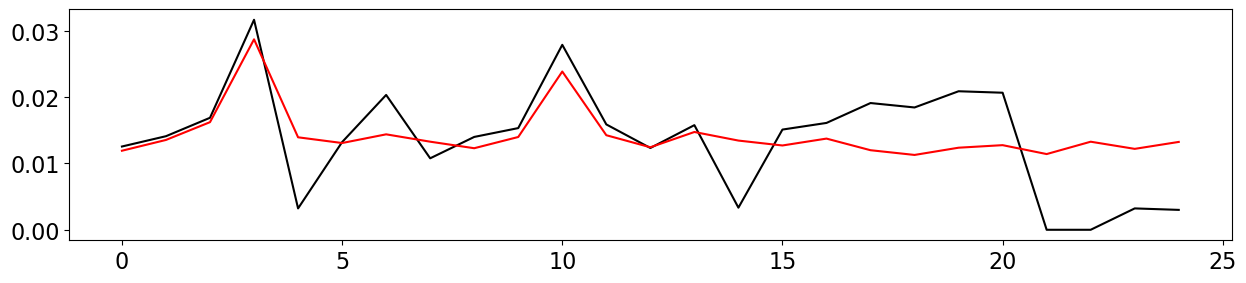

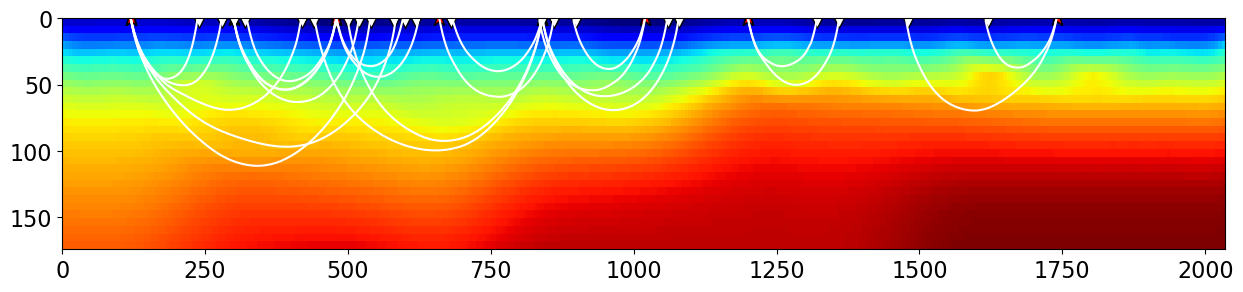

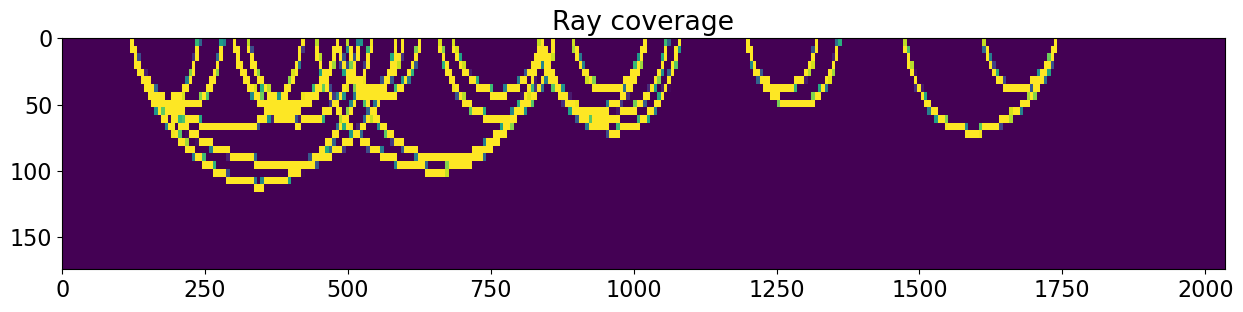

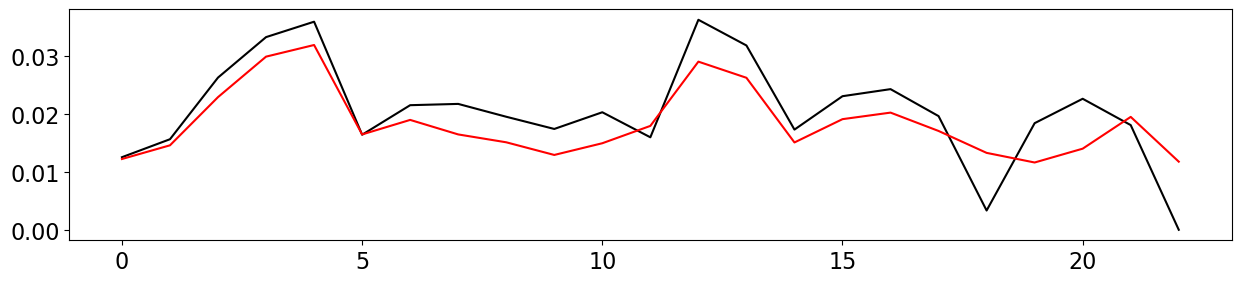

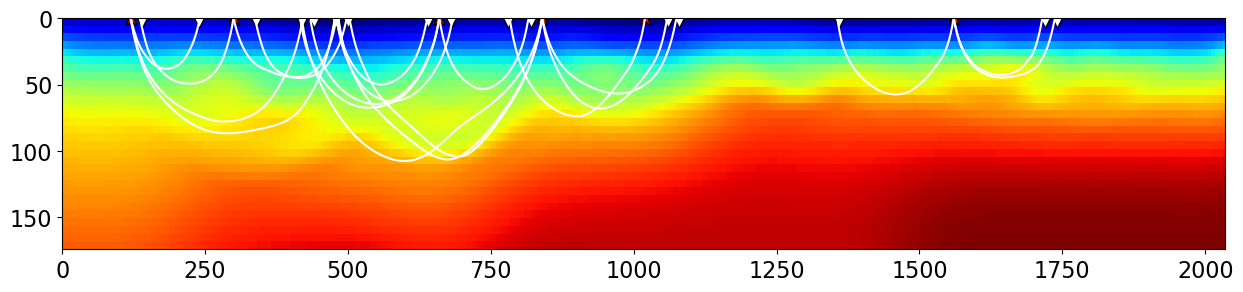

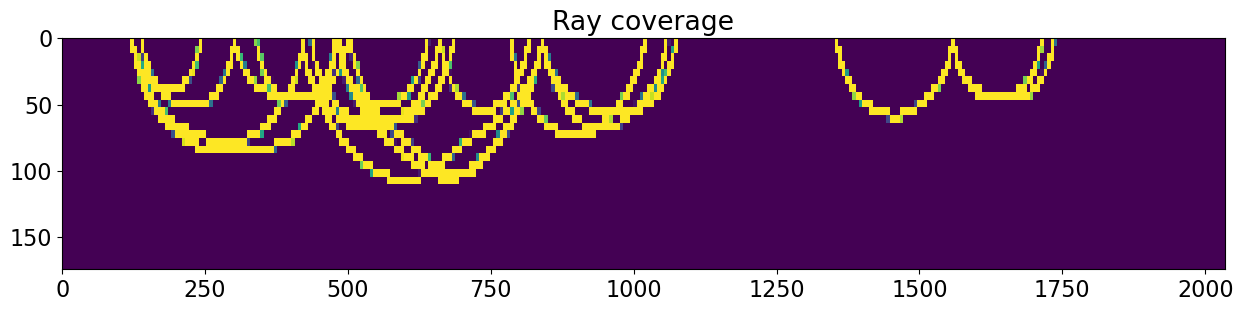

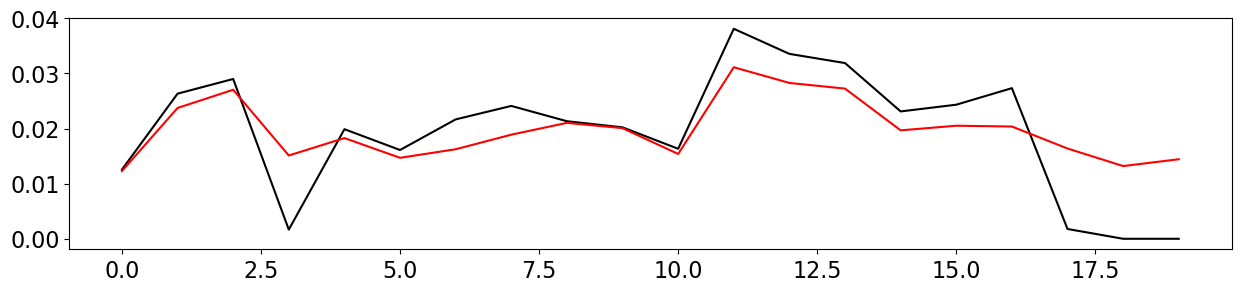

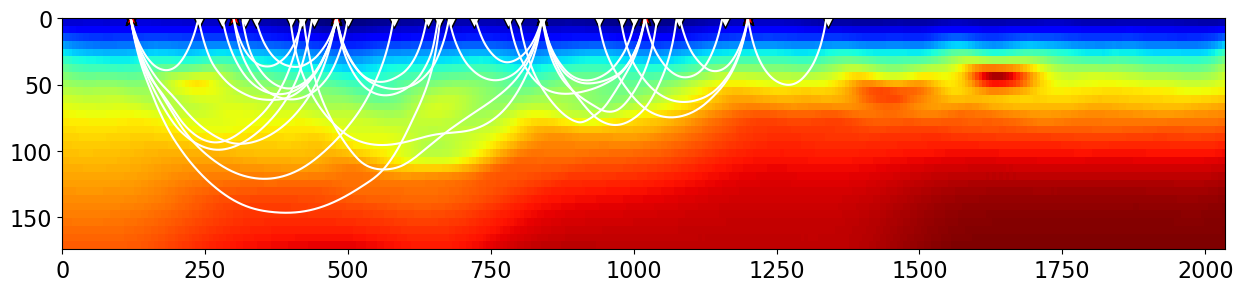

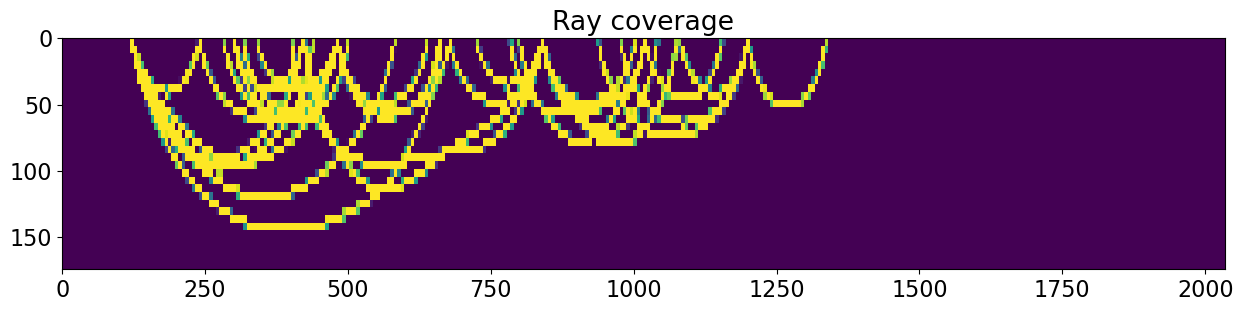

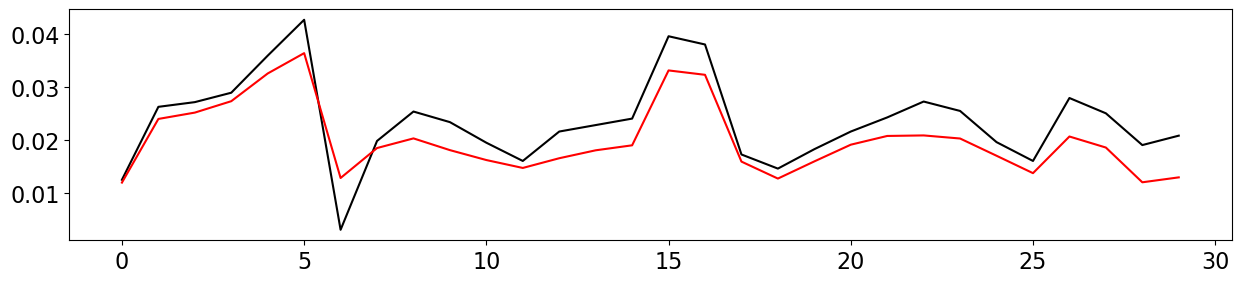

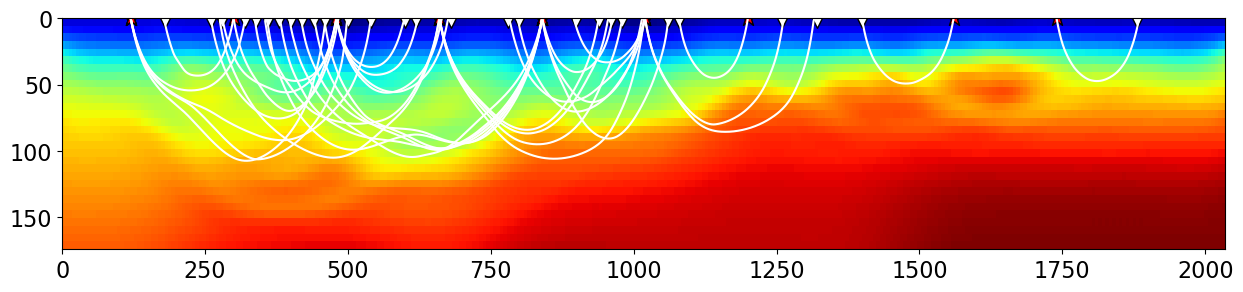

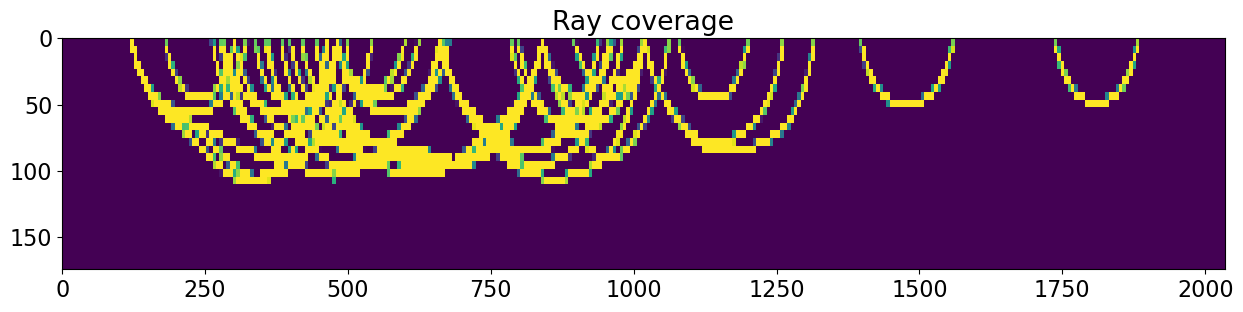

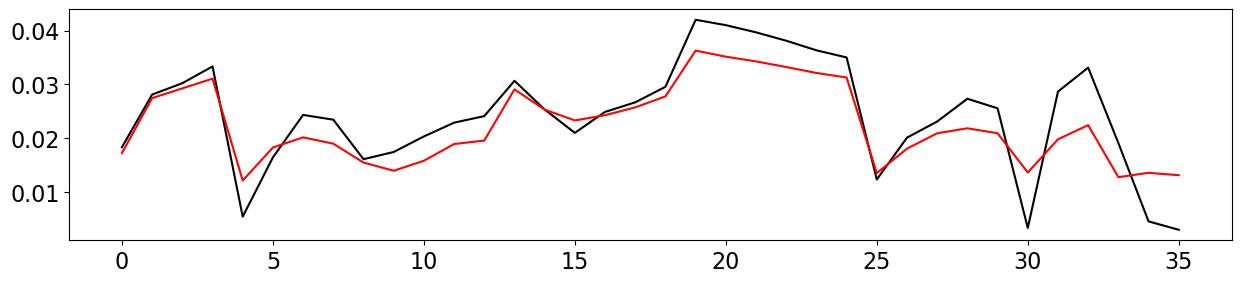

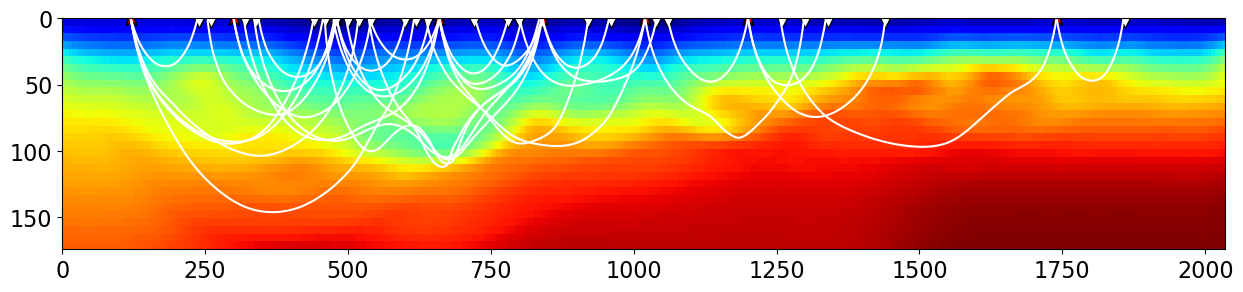

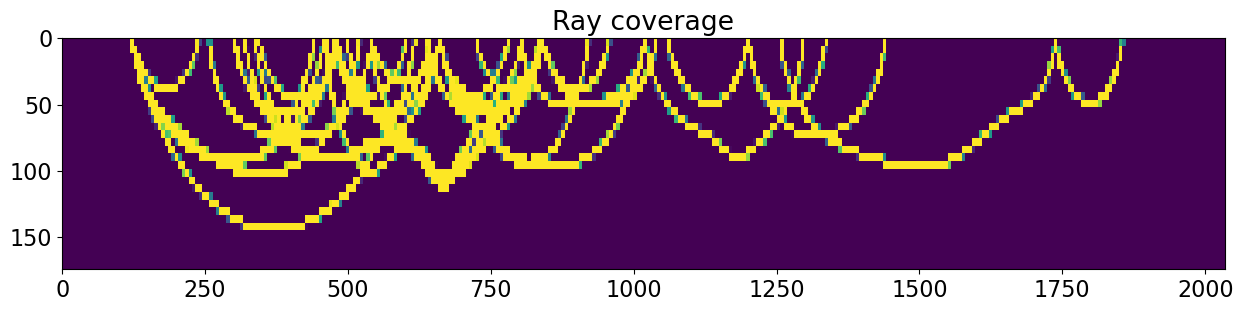

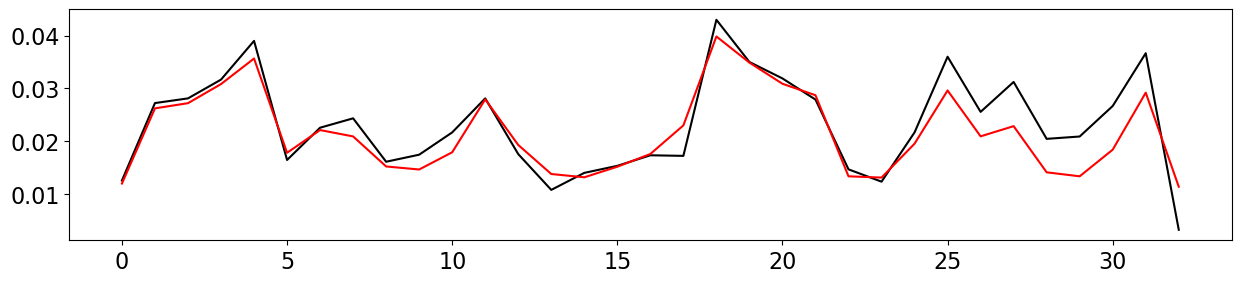

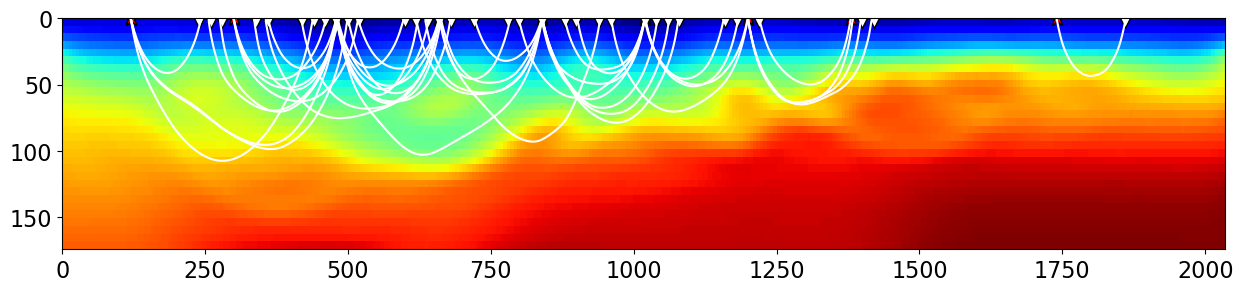

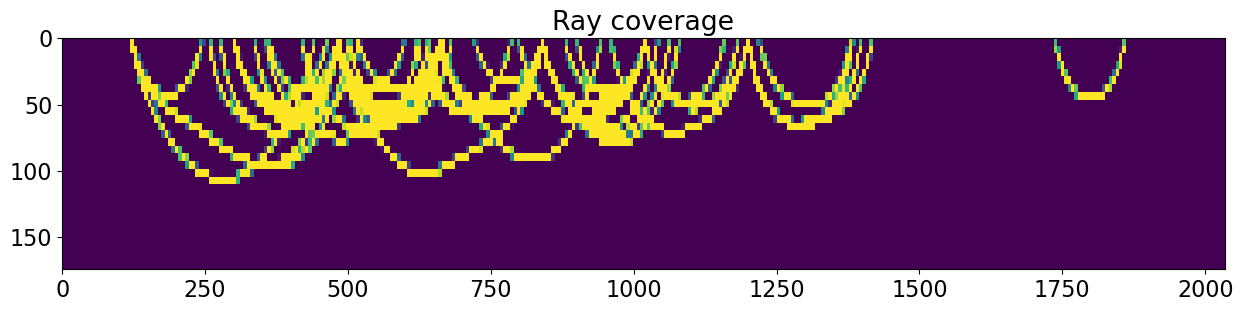

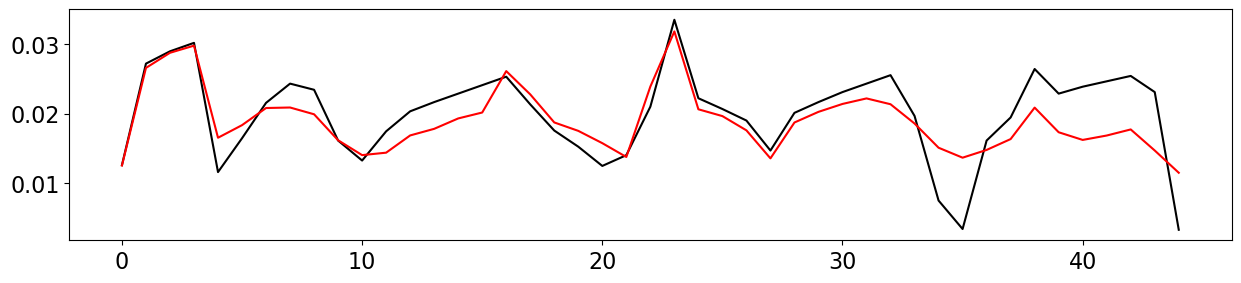

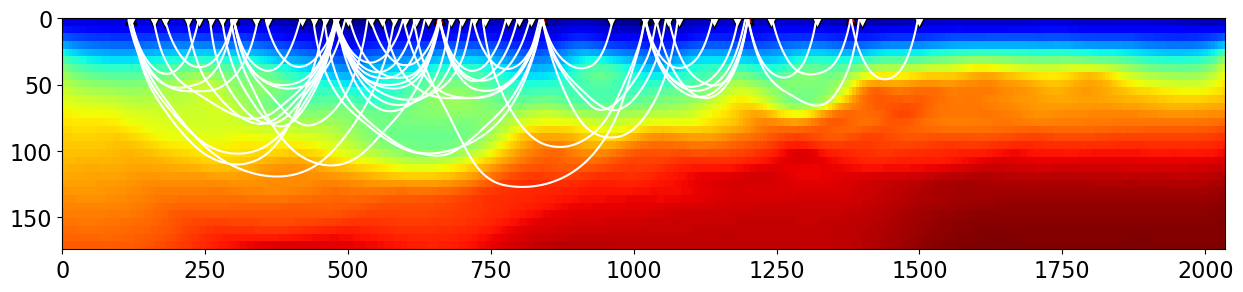

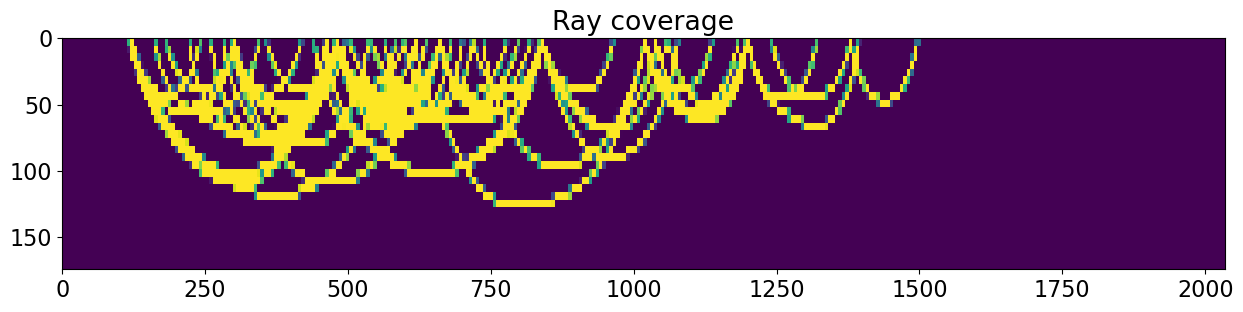

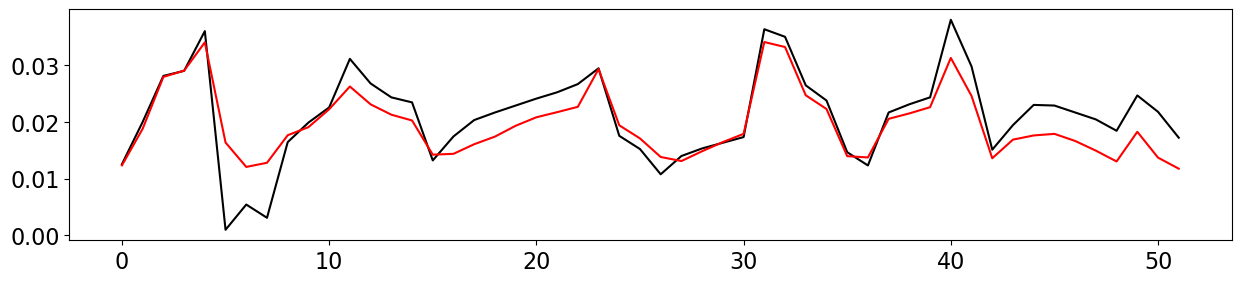

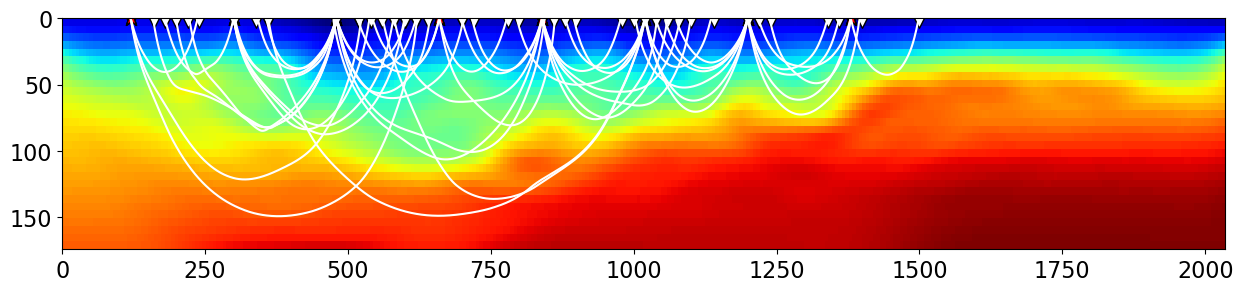

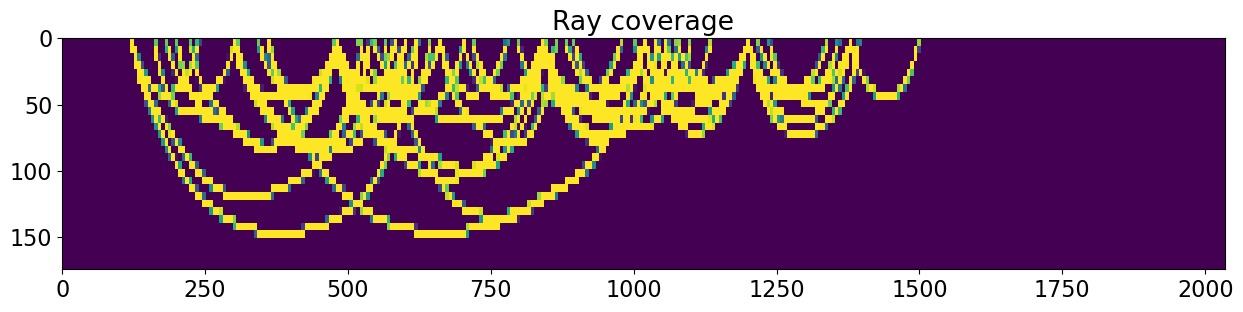

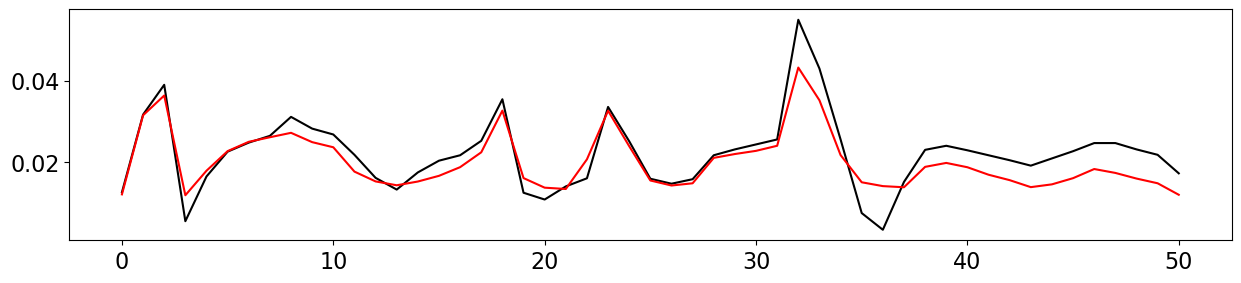

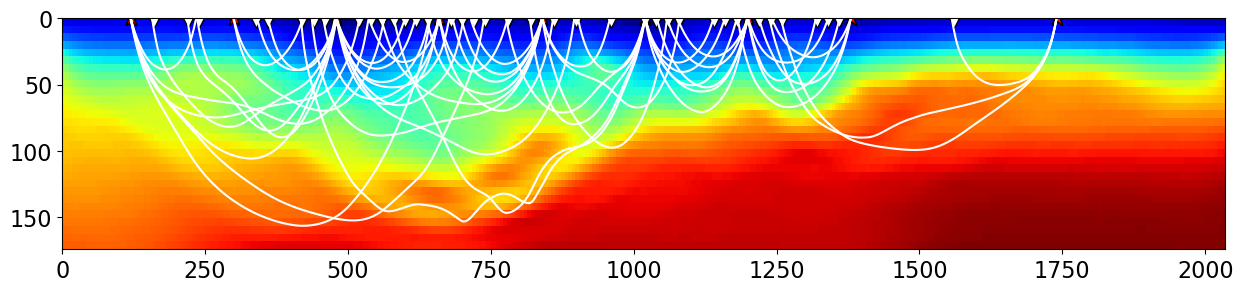

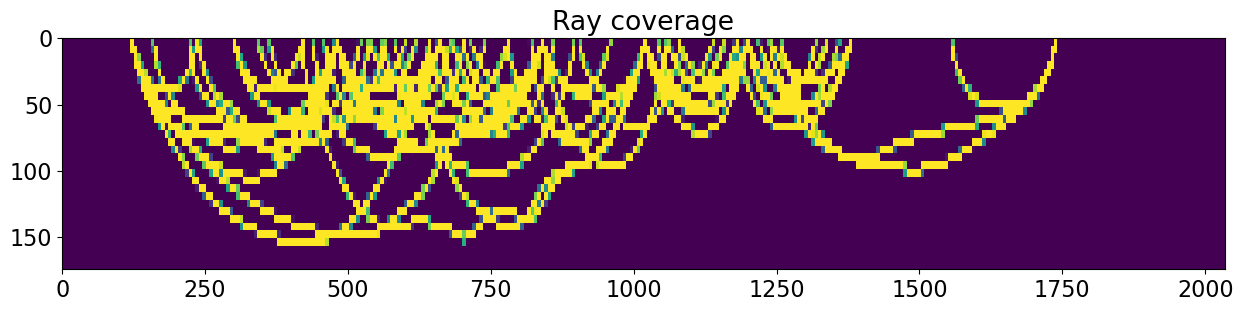

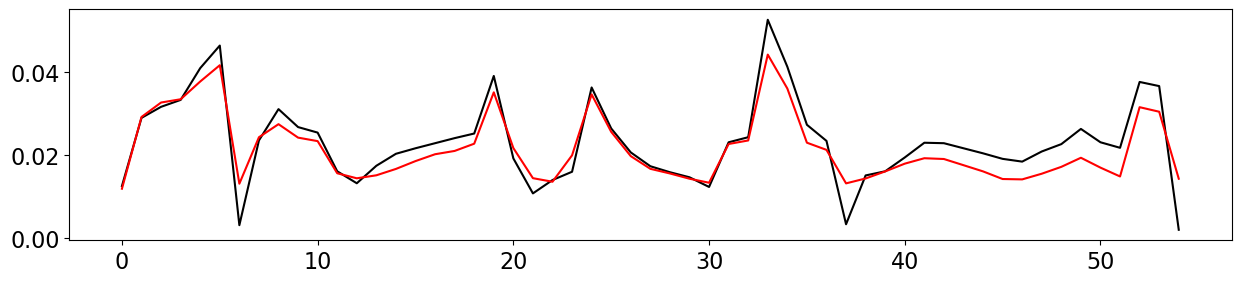

In [11]:
# second version, updating dslow with full dtobs at each step
ngniter = 10

Dop = Laplacian((nx, nz), weights=(10, 1))
vel_inv = vel_init.copy()
slown_inv = 1. / vel_inv.ravel()
misfit = []
for iiter in range(ngniter):
    # Raytrace in initial model
    invsurvey = survey_raytrace(survey, vel_inv.T, x, z, lmax, nl, thetas, dzout=5., ray_rec_mindistance=5., debug=True)

    # Match surveys
    avasurvey_matched, invsurvey_matched = match_surveys(avasurvey, invsurvey, debug=True)

    # Tomographic matrix and traveltimes
    Rinv = tomographic_matrix(invsurvey_matched, dx, dz, 0, 0, nx, nz, x, z, debug=True, plotflag=True, vel=vel_inv)
    tobs = extract_tobs(avasurvey_matched)
    tinv = Rinv @ slown_inv
    
    # Residual data
    dtobs = tobs - tinv
    misfit.append(np.linalg.norm(tobs - tinv) / len(tobs))
    print(f'Iteration {iiter+1}/{ngniter}, Misfit {misfit[-1]:.4f}')
    plt.figure(figsize=(15, 3))
    plt.plot(tobs, 'k')
    plt.plot(tinv, 'r')
    
    # Invert slowness update (just few iterations to avoid overfitting at each step)
    dslown_inv = regularized_inversion(MatrixMult(Rinv), 
                                       dtobs, [Dop,], 
                                       epsRs=[1e2,], dataregs=[-Dop * slown_inv.ravel(), ], 
                                       **dict(iter_lim=40, damp=1e-1))[0]
    slown_inv += dslown_inv
    vel_inv = 1. / (slown_inv.reshape(nx, nz) + 1e-10)

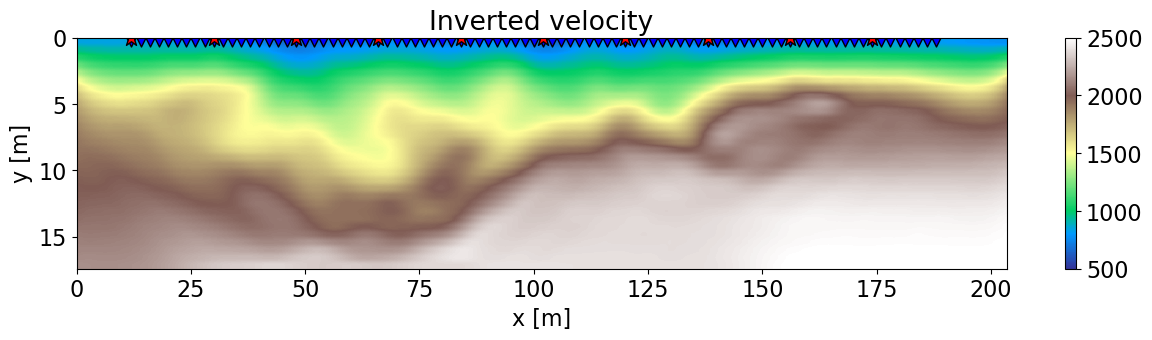

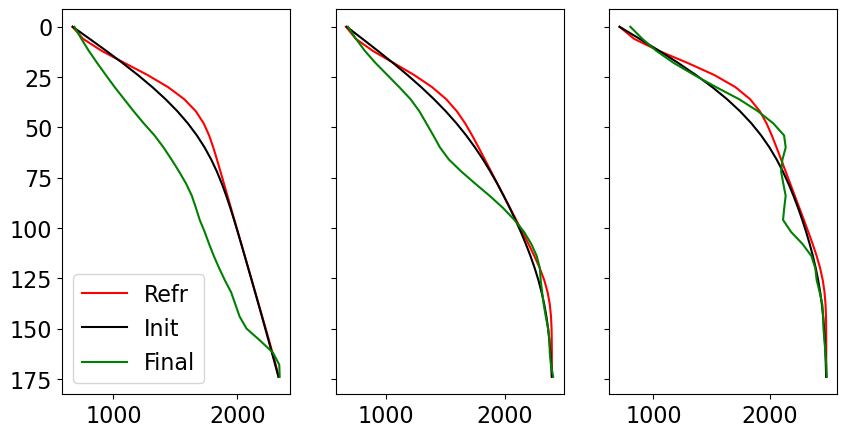

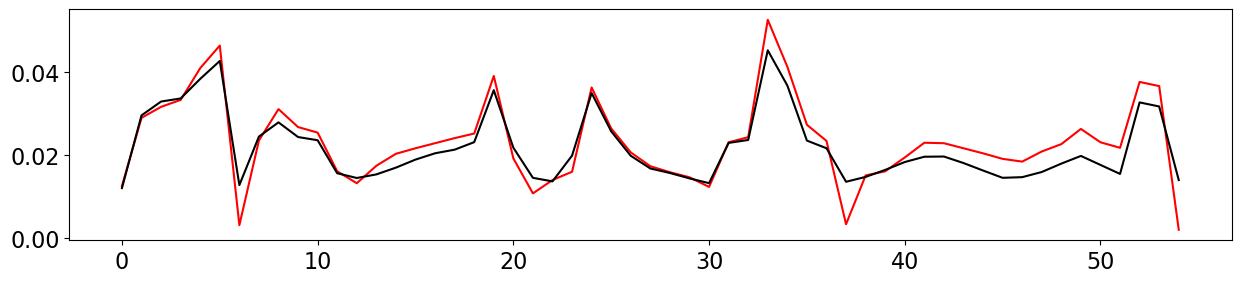

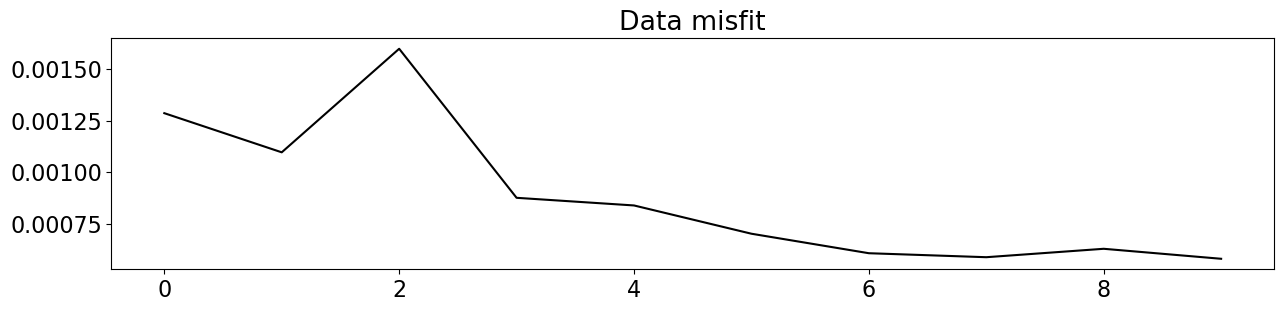

In [12]:
plt.figure(figsize=(15, 3))
im = plt.imshow(vel_inv.T / sc, cmap='terrain', vmin=500, vmax=2500, 
                extent=(x[0] / sc, x[-1] / sc, z[-1] / sc, z[0] / sc))
plt.scatter(recs[0] / sc, recs[1] / sc, marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0] / sc, sources[1] / sc, marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Inverted velocity')
plt.ylim(z[-1] / sc, z[0] / sc)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
for ax, ix in zip(axs, [nx//4, nx//2, 3*nx//4]):
    ax.plot(vel_refr[ix] / sc, z, 'r', label='Refr')
    ax.plot(vel_init[ix] / sc, z, 'k', label='Init')
    ax.plot(vel_inv[ix] / sc, z, 'g', label='Final')
    if ix == nx // 4:
        ax.legend()
axs[-1].invert_yaxis()

tinv = Rinv @ (1/vel_inv.ravel())

plt.figure(figsize=(15, 3))
plt.plot(tobs, 'r')
plt.plot(tinv, 'k')

plt.figure(figsize=(15, 3))
plt.plot(misfit, 'k')
plt.title('Data misfit');